In [1]:
import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as tf
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp


In [2]:

device = os.environ["DEVICE"]
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils', )

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224
TARGET_CROP = torchvision.transforms.CenterCrop((36, 64))

class CachedImageNet(ImageNet):
    def __init__(self, root, split, transform=None, feature_extractor=None, version='0.1'):
        super().__init__(root=root, split=split, transform=transform)
        self.feature_extractor = feature_extractor  # Function to extract features
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
        self.resnet50.eval().to(device)
        self.resnet_layer = self.resnet50.layers[2][0].downsample[0]


    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        # Cache file path
        cache_path = self._get_cache_path(index)

        # Load feature from cache if it exists

        img = img.unsqueeze(0)  # Add batch dimension
        grayscale_img_rgb = F.rgb_to_grayscale(img, num_output_channels=3).to(device)
        features_path = os.path.join(self.cache_dir, f'feature_{index}.pt')

        if os.path.exists(cache_path):
            saved_features = torch.load(cache_path).to(device)
            if random() < 0.01: # check if the cache is correct
                features = None
                def assign_features(module, input, output):
                    nonlocal features
                    features = output
                hook = self.resnet_layer.register_forward_hook(assign_features)
                
                with torch.no_grad():
                    self.resnet50(grayscale_img_rgb)
                hook.remove()
                assert features is not None
                assert torch.equal(saved_features, features)
            features = saved_features

        else:
            # Compute feature if not cached

            features = None
            def assign_features(module, input, output):
                nonlocal features
                features = output
            hook = self.resnet_layer.register_forward_hook(assign_features)
            
            with torch.no_grad():
                self.resnet50(grayscale_img_rgb)
            hook.remove()
            assert features is not None

            torch.save(features, cache_path)  # Save to cache
        
        # center crop
        target = TARGET_CROP(F.rgb_to_grayscale(img, num_output_channels=1))
        return grayscale_img_rgb, features, target
# Image transformations
train_transforms = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Example feature extractor: compute mean/std per channel

def feature_extractor(img):
    img_np = np.array(img)
    mean = np.mean(img_np, axis=(0, 1))
    std = np.std(img_np, axis=(0, 1))
    return torch.tensor(np.concatenate([mean, std]))
# Dataset path


# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split='val',
    transform=train_transforms,
    feature_extractor=feature_extractor,
    version='0.5'
)

from torch.utils.data import random_split, DataLoader

# Define the split sizes
train_size = int(0.8 * len(train_dataset))  # 80% for training
test_size = len(train_dataset) - train_size  # 20% for testing
print("Train size:", train_size)
print("Test size:", test_size)

# Split the dataset
train_subset, test_subset = random_split(train_dataset, [train_size, test_size])

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=64,
    # shuffle=True,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=64,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Train size: 40000
Test size: 10000


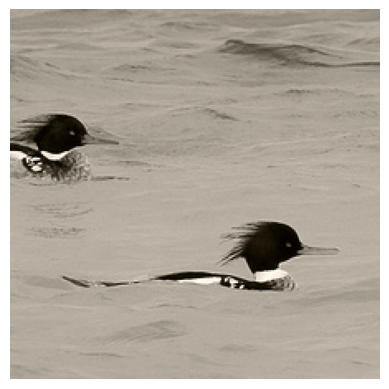

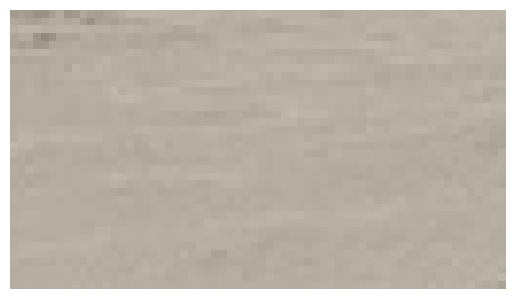

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    mean = np.array([0.485, 0.456, 0.406])  # ImageNet normalization mean
    std = np.array([0.229, 0.224, 0.225])  # ImageNet normalization std
    img = std * img + mean  # De-normalize
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
images, features, targets = next(data_iter)
show_image(images[2][0, ...])  # Show the first image in the batch
show_image(targets[2][0, ...])  # Show the first image in the batch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as f2

class LogisticRegressor(nn.Module):
    def __init__(self, feature_dim, output_dim):
        """
        Logistic Regression Model
        :param feature_dim: Flattened input feature size
        :param output_dim: Number of outputs (1 for binary classification)
        """
        super(LogisticRegressor, self).__init__()
        self.linear = nn.Linear(feature_dim, output_dim)
        
    def forward(self, x):
        logits = self.linear(x)  # Compute raw scores
        probs = torch.sigmoid(logits)  # Apply sigmoid for binary classification
        return probs
class SingleLayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, alpha=1.0):
        """
        Single-layer MLP for regression.
        :param input_dim: Input feature size (flattened)
        :param hidden_dim: Number of hidden units
        :param output_dim: Number of outputs (target size)
        :param alpha: Regularization strength
        """
        super(SingleLayerMLP, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.alpha = alpha

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

# Model parameters
batch_size = 64
feature_shape = (1024, 14, 14)  # Provided feature shape
flattened_feature_size = torch.prod(torch.tensor(feature_shape)).item()

output_size = 36 * 64  # Flattened target shape (36x64 from TARGET_CROP)
# Model parameters
hidden_units = 512 # Number of hidden units in the MLP
mlp_model = SingleLayerMLP(flattened_feature_size, hidden_units, output_size, alpha=1.0).to(device)

# Loss and optimizer2481825
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Training Loop
num_epochs = 1 # Number of epochs
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    mlp_model.train()
    running_loss = 0.0

    for grayscale_img, features, target in tqdm(train_loader):
        features = features.to(device)  # Move to device
        target = target.view(target.size(0), -1).to(device)  # Flatten target

        # Flatten features
        features = features.view(features.size(0), -1)

        # Forward pass
        outputs = mlp_model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # constant_guess = torch.mean(target, dim=(-1, -2), keepdim=True)
        constant_guess_loss = criterion(torch.full_like(target, 0), target)
        print(f"Constant guess loss: {constant_guess_loss.item()}")
        print(f"Loss: {loss.item()}")


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
       





  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 1/625 [00:00<05:36,  1.85it/s]

Constant guess loss: 1.3408781290054321
Loss: 1.3525831699371338


  0%|          | 2/625 [00:01<10:10,  1.02it/s]

Constant guess loss: 1.220340371131897
Loss: 51.7713623046875


  0%|          | 3/625 [00:02<10:44,  1.04s/it]

Constant guess loss: 1.310585856437683
Loss: 7.7409186363220215


  1%|          | 4/625 [00:04<10:57,  1.06s/it]

Constant guess loss: 1.3815133571624756
Loss: 1.9375824928283691


  1%|          | 5/625 [00:04<10:30,  1.02s/it]

Constant guess loss: 1.1866029500961304
Loss: 1.4893804788589478


  1%|          | 6/625 [00:06<10:39,  1.03s/it]

Constant guess loss: 1.243584156036377
Loss: 1.4916554689407349


  1%|          | 7/625 [00:07<11:24,  1.11s/it]

Constant guess loss: 1.1389049291610718
Loss: 1.1395334005355835


  1%|▏         | 8/625 [00:08<11:34,  1.12s/it]

Constant guess loss: 1.2324739694595337
Loss: 1.4322158098220825


  1%|▏         | 9/625 [00:09<11:33,  1.13s/it]

Constant guess loss: 1.2824262380599976
Loss: 1.2828710079193115


  2%|▏         | 10/625 [00:10<11:48,  1.15s/it]

Constant guess loss: 1.0666300058364868
Loss: 1.067260503768921


  2%|▏         | 11/625 [00:11<11:07,  1.09s/it]

Constant guess loss: 1.3464583158493042
Loss: 1.486134648323059


  2%|▏         | 12/625 [00:13<12:14,  1.20s/it]

Constant guess loss: 1.5797569751739502
Loss: 1.7568832635879517


  2%|▏         | 13/625 [00:14<12:19,  1.21s/it]

Constant guess loss: 1.2619309425354004
Loss: 1.2623519897460938


  2%|▏         | 14/625 [00:15<12:35,  1.24s/it]

Constant guess loss: 1.5907609462738037
Loss: 1.7653892040252686


  2%|▏         | 15/625 [00:16<12:41,  1.25s/it]

Constant guess loss: 1.4078725576400757
Loss: 1.5703952312469482


  3%|▎         | 16/625 [00:18<12:14,  1.21s/it]

Constant guess loss: 1.2923660278320312
Loss: 1.29276442527771


  3%|▎         | 17/625 [00:19<12:07,  1.20s/it]

Constant guess loss: 1.156432867050171
Loss: 1.1565971374511719


  3%|▎         | 18/625 [00:20<11:41,  1.16s/it]

Constant guess loss: 1.0025842189788818
Loss: 1.002785325050354


  3%|▎         | 19/625 [00:21<11:39,  1.15s/it]

Constant guess loss: 1.1616071462631226
Loss: 1.1629048585891724


  3%|▎         | 20/625 [00:22<11:59,  1.19s/it]

Constant guess loss: 1.247772216796875
Loss: 1.2481915950775146


  3%|▎         | 21/625 [00:23<10:56,  1.09s/it]

Constant guess loss: 1.3901933431625366
Loss: 1.3906009197235107


  4%|▎         | 22/625 [00:24<11:14,  1.12s/it]

Constant guess loss: 1.4456169605255127
Loss: 1.446376085281372


  4%|▎         | 23/625 [00:26<11:39,  1.16s/it]

Constant guess loss: 1.237910270690918
Loss: 1.2379019260406494


  4%|▍         | 24/625 [00:27<11:51,  1.18s/it]

Constant guess loss: 1.3780179023742676
Loss: 1.3782168626785278


  4%|▍         | 25/625 [00:28<11:10,  1.12s/it]

Constant guess loss: 1.4986661672592163
Loss: 1.4995373487472534


  4%|▍         | 26/625 [00:29<11:07,  1.11s/it]

Constant guess loss: 0.9963545203208923
Loss: 1.1289736032485962


  4%|▍         | 27/625 [00:30<11:19,  1.14s/it]

Constant guess loss: 1.4620513916015625
Loss: 1.4629029035568237


  4%|▍         | 28/625 [00:31<11:19,  1.14s/it]

Constant guess loss: 1.3707493543624878
Loss: 1.37142014503479


  5%|▍         | 29/625 [00:32<11:29,  1.16s/it]

Constant guess loss: 1.1953589916229248
Loss: 1.1945924758911133


  5%|▍         | 30/625 [00:34<12:33,  1.27s/it]

Constant guess loss: 1.1930075883865356
Loss: 1.1924999952316284


  5%|▍         | 31/625 [00:35<13:14,  1.34s/it]

Constant guess loss: 1.2558399438858032
Loss: 1.2562609910964966


  5%|▌         | 32/625 [00:37<12:45,  1.29s/it]

Constant guess loss: 1.2195841073989868
Loss: 1.22016179561615


  5%|▌         | 33/625 [00:38<11:49,  1.20s/it]

Constant guess loss: 1.3018637895584106
Loss: 1.3008772134780884


  5%|▌         | 34/625 [00:39<11:16,  1.14s/it]

Constant guess loss: 1.2403769493103027
Loss: 1.2403367757797241


  6%|▌         | 35/625 [00:40<11:06,  1.13s/it]

Constant guess loss: 1.4802550077438354
Loss: 1.4806158542633057


  6%|▌         | 36/625 [00:41<11:16,  1.15s/it]

Constant guess loss: 1.2704565525054932
Loss: 1.2716397047042847


  6%|▌         | 37/625 [00:42<11:31,  1.18s/it]

Constant guess loss: 1.1908705234527588
Loss: 1.1911289691925049


  6%|▌         | 38/625 [00:43<11:16,  1.15s/it]

Constant guess loss: 1.288042664527893
Loss: 1.289341688156128


  6%|▌         | 39/625 [00:44<11:32,  1.18s/it]

Constant guess loss: 1.327832579612732
Loss: 1.3278179168701172


  6%|▋         | 40/625 [00:46<11:05,  1.14s/it]

Constant guess loss: 1.3006442785263062
Loss: 1.3002562522888184


  7%|▋         | 41/625 [00:47<11:10,  1.15s/it]

Constant guess loss: 1.3442659378051758
Loss: 1.3449292182922363


  7%|▋         | 42/625 [00:48<11:15,  1.16s/it]

Constant guess loss: 1.3389909267425537
Loss: 1.3402231931686401


  7%|▋         | 43/625 [00:49<11:16,  1.16s/it]

Constant guess loss: 1.173690915107727
Loss: 1.1736433506011963


  7%|▋         | 44/625 [00:50<11:12,  1.16s/it]

Constant guess loss: 1.3343632221221924
Loss: 1.3350785970687866


  7%|▋         | 45/625 [00:52<11:52,  1.23s/it]

Constant guess loss: 1.4790979623794556
Loss: 1.480087399482727


  7%|▋         | 46/625 [00:53<11:47,  1.22s/it]

Constant guess loss: 1.3006885051727295
Loss: 1.301190972328186


  8%|▊         | 47/625 [00:54<11:56,  1.24s/it]

Constant guess loss: 1.4062273502349854
Loss: 1.4051330089569092


  8%|▊         | 48/625 [00:55<11:18,  1.18s/it]

Constant guess loss: 1.4113155603408813
Loss: 1.4103754758834839


  8%|▊         | 49/625 [00:56<11:14,  1.17s/it]

Constant guess loss: 1.2845240831375122
Loss: 1.2838869094848633


  8%|▊         | 50/625 [00:57<11:09,  1.16s/it]

Constant guess loss: 1.2271461486816406
Loss: 1.2282384634017944


  8%|▊         | 51/625 [00:59<11:28,  1.20s/it]

Constant guess loss: 1.310398817062378
Loss: 1.3099621534347534


  8%|▊         | 52/625 [01:00<11:35,  1.21s/it]

Constant guess loss: 1.2386213541030884
Loss: 1.2368799448013306


  8%|▊         | 53/625 [01:01<11:33,  1.21s/it]

Constant guess loss: 1.301675796508789
Loss: 1.3009802103042603


  9%|▊         | 54/625 [01:02<11:22,  1.20s/it]

Constant guess loss: 1.4051882028579712
Loss: 1.4061723947525024


  9%|▉         | 55/625 [01:03<11:03,  1.16s/it]

Constant guess loss: 1.196332335472107
Loss: 1.193555474281311


  9%|▉         | 56/625 [01:05<11:10,  1.18s/it]

Constant guess loss: 1.2783877849578857
Loss: 1.2782913446426392


  9%|▉         | 57/625 [01:06<10:48,  1.14s/it]

Constant guess loss: 1.4164988994598389
Loss: 1.4158809185028076


  9%|▉         | 58/625 [01:07<10:12,  1.08s/it]

Constant guess loss: 1.3816015720367432
Loss: 1.382774829864502


  9%|▉         | 59/625 [01:08<09:58,  1.06s/it]

Constant guess loss: 1.2946199178695679
Loss: 1.294113278388977


 10%|▉         | 60/625 [01:09<09:58,  1.06s/it]

Constant guess loss: 1.24186372756958
Loss: 1.2401407957077026


 10%|▉         | 61/625 [01:10<11:04,  1.18s/it]

Constant guess loss: 1.2305376529693604
Loss: 1.229483962059021


 10%|▉         | 62/625 [01:11<10:28,  1.12s/it]

Constant guess loss: 1.2312349081039429
Loss: 1.2317290306091309


 10%|█         | 63/625 [01:12<10:33,  1.13s/it]

Constant guess loss: 1.2653387784957886
Loss: 1.2651424407958984


 10%|█         | 64/625 [01:13<10:34,  1.13s/it]

Constant guess loss: 1.370198369026184
Loss: 1.370804786682129


 10%|█         | 65/625 [01:15<10:30,  1.13s/it]

Constant guess loss: 1.096118450164795
Loss: 1.0962963104248047


 11%|█         | 66/625 [01:16<10:57,  1.18s/it]

Constant guess loss: 1.3681055307388306
Loss: 1.3693610429763794


 11%|█         | 67/625 [01:17<11:12,  1.21s/it]

Constant guess loss: 1.3776824474334717
Loss: 1.3739973306655884


 11%|█         | 68/625 [01:18<10:45,  1.16s/it]

Constant guess loss: 1.1667624711990356
Loss: 1.1658432483673096


 11%|█         | 69/625 [01:19<10:13,  1.10s/it]

Constant guess loss: 1.1276832818984985
Loss: 1.1251797676086426


 11%|█         | 70/625 [01:20<10:53,  1.18s/it]

Constant guess loss: 1.1730458736419678
Loss: 1.173966884613037


 11%|█▏        | 71/625 [01:22<11:16,  1.22s/it]

Constant guess loss: 1.2902809381484985
Loss: 1.2917829751968384


 12%|█▏        | 72/625 [01:23<10:49,  1.17s/it]

Constant guess loss: 1.1391582489013672
Loss: 1.1395145654678345


 12%|█▏        | 73/625 [01:24<10:28,  1.14s/it]

Constant guess loss: 1.18021821975708
Loss: 1.1797467470169067


 12%|█▏        | 74/625 [01:25<10:20,  1.13s/it]

Constant guess loss: 1.2641843557357788
Loss: 1.2654900550842285


 12%|█▏        | 75/625 [01:26<10:26,  1.14s/it]

Constant guess loss: 1.2487026453018188
Loss: 1.2463433742523193


 12%|█▏        | 76/625 [01:27<10:22,  1.13s/it]

Constant guess loss: 1.2940677404403687
Loss: 1.2952624559402466


 12%|█▏        | 77/625 [01:28<10:22,  1.14s/it]

Constant guess loss: 1.383508324623108
Loss: 1.3846101760864258


 12%|█▏        | 78/625 [01:30<10:16,  1.13s/it]

Constant guess loss: 1.4832167625427246
Loss: 1.4824597835540771


 13%|█▎        | 79/625 [01:31<10:11,  1.12s/it]

Constant guess loss: 1.3758776187896729
Loss: 1.3776286840438843


 13%|█▎        | 80/625 [01:32<10:05,  1.11s/it]

Constant guess loss: 1.087847113609314
Loss: 1.0865330696105957


 13%|█▎        | 81/625 [01:33<10:02,  1.11s/it]

Constant guess loss: 1.3791803121566772
Loss: 1.3783966302871704


 13%|█▎        | 82/625 [01:34<09:57,  1.10s/it]

Constant guess loss: 1.440460205078125
Loss: 1.4393937587738037


 13%|█▎        | 83/625 [01:35<09:46,  1.08s/it]

Constant guess loss: 1.3923143148422241
Loss: 1.3920408487319946


 13%|█▎        | 84/625 [01:36<10:12,  1.13s/it]

Constant guess loss: 1.2823926210403442
Loss: 1.2873034477233887


 14%|█▎        | 85/625 [01:37<10:39,  1.18s/it]

Constant guess loss: 1.4045147895812988
Loss: 1.4038454294204712


 14%|█▍        | 86/625 [01:39<10:29,  1.17s/it]

Constant guess loss: 1.1990407705307007
Loss: 1.2000081539154053


 14%|█▍        | 87/625 [01:42<15:27,  1.72s/it]

Constant guess loss: 1.2740827798843384
Loss: 1.27248215675354


 14%|█▍        | 88/625 [01:43<13:47,  1.54s/it]

Constant guess loss: 1.2967209815979004
Loss: 1.295053482055664


 14%|█▍        | 89/625 [01:44<12:47,  1.43s/it]

Constant guess loss: 1.22482168674469
Loss: 1.223926305770874


 14%|█▍        | 90/625 [01:45<12:25,  1.39s/it]

Constant guess loss: 1.2622843980789185
Loss: 1.2640587091445923


 15%|█▍        | 91/625 [01:47<12:15,  1.38s/it]

Constant guess loss: 1.1559077501296997
Loss: 1.1550215482711792


 15%|█▍        | 92/625 [01:48<11:39,  1.31s/it]

Constant guess loss: 1.3413647413253784
Loss: 1.3417669534683228


 15%|█▍        | 93/625 [01:49<11:21,  1.28s/it]

Constant guess loss: 1.2288005352020264
Loss: 1.2259920835494995


 15%|█▌        | 94/625 [01:50<10:16,  1.16s/it]

Constant guess loss: 1.303267478942871
Loss: 1.3030811548233032


 15%|█▌        | 95/625 [01:51<09:53,  1.12s/it]

Constant guess loss: 1.356400489807129
Loss: 1.3564889430999756


 15%|█▌        | 96/625 [01:52<09:56,  1.13s/it]

Constant guess loss: 1.3978462219238281
Loss: 1.394032597541809


 16%|█▌        | 97/625 [01:53<10:40,  1.21s/it]

Constant guess loss: 1.2418166399002075
Loss: 1.2420748472213745


 16%|█▌        | 98/625 [01:55<10:40,  1.22s/it]

Constant guess loss: 1.16403067111969
Loss: 1.1607471704483032


 16%|█▌        | 99/625 [01:56<10:46,  1.23s/it]

Constant guess loss: 1.2288322448730469
Loss: 1.2300865650177002


 16%|█▌        | 100/625 [01:57<11:21,  1.30s/it]

Constant guess loss: 1.4287887811660767
Loss: 1.4246900081634521


 16%|█▌        | 101/625 [01:59<11:02,  1.26s/it]

Constant guess loss: 1.28194260597229
Loss: 1.2774583101272583


 16%|█▋        | 102/625 [02:00<10:46,  1.24s/it]

Constant guess loss: 1.1786561012268066
Loss: 1.180323600769043


 16%|█▋        | 103/625 [02:01<10:07,  1.16s/it]

Constant guess loss: 1.3345850706100464
Loss: 1.3352335691452026


 17%|█▋        | 104/625 [02:02<10:05,  1.16s/it]

Constant guess loss: 1.3996492624282837
Loss: 1.397046685218811


 17%|█▋        | 105/625 [02:03<09:49,  1.13s/it]

Constant guess loss: 1.3879352807998657
Loss: 1.3836580514907837


 17%|█▋        | 106/625 [02:04<10:12,  1.18s/it]

Constant guess loss: 1.346143364906311
Loss: 1.3426231145858765


 17%|█▋        | 107/625 [02:05<10:15,  1.19s/it]

Constant guess loss: 1.5088649988174438
Loss: 1.5087671279907227


 17%|█▋        | 108/625 [02:06<09:48,  1.14s/it]

Constant guess loss: 1.1540367603302002
Loss: 1.154451847076416


 17%|█▋        | 109/625 [02:07<09:28,  1.10s/it]

Constant guess loss: 1.289595603942871
Loss: 1.2880464792251587


 18%|█▊        | 110/625 [02:09<09:50,  1.15s/it]

Constant guess loss: 1.2006045579910278
Loss: 1.1998956203460693


 18%|█▊        | 111/625 [02:10<09:39,  1.13s/it]

Constant guess loss: 1.2719923257827759
Loss: 1.2664350271224976


 18%|█▊        | 112/625 [02:11<09:32,  1.12s/it]

Constant guess loss: 1.40934157371521
Loss: 1.4100663661956787


 18%|█▊        | 113/625 [02:12<10:40,  1.25s/it]

Constant guess loss: 1.3079341650009155
Loss: 1.3017226457595825


 18%|█▊        | 114/625 [02:14<10:10,  1.19s/it]

Constant guess loss: 1.293215036392212
Loss: 1.2956016063690186


 18%|█▊        | 115/625 [02:15<10:12,  1.20s/it]

Constant guess loss: 1.1779496669769287
Loss: 1.1801316738128662


 19%|█▊        | 116/625 [02:16<10:22,  1.22s/it]

Constant guess loss: 1.2085548639297485
Loss: 1.208931565284729


 19%|█▊        | 117/625 [02:17<10:08,  1.20s/it]

Constant guess loss: 1.1772074699401855
Loss: 1.1759023666381836


 19%|█▉        | 118/625 [02:18<09:49,  1.16s/it]

Constant guess loss: 1.0994614362716675
Loss: 1.0999042987823486


 19%|█▉        | 119/625 [02:19<09:51,  1.17s/it]

Constant guess loss: 1.336045742034912
Loss: 1.3352227210998535


 19%|█▉        | 120/625 [02:21<10:11,  1.21s/it]

Constant guess loss: 1.3550440073013306
Loss: 1.3560378551483154


 19%|█▉        | 121/625 [02:22<10:01,  1.19s/it]

Constant guess loss: 1.16196870803833
Loss: 1.1589264869689941


 20%|█▉        | 122/625 [02:23<09:51,  1.18s/it]

Constant guess loss: 1.4157320261001587
Loss: 1.4137827157974243


 20%|█▉        | 123/625 [02:24<10:00,  1.20s/it]

Constant guess loss: 1.3090367317199707
Loss: 1.3042160272598267


 20%|█▉        | 124/625 [02:26<10:38,  1.28s/it]

Constant guess loss: 1.4855948686599731
Loss: 1.484410285949707


 20%|██        | 125/625 [02:27<10:45,  1.29s/it]

Constant guess loss: 1.4068902730941772
Loss: 1.4040061235427856


 20%|██        | 126/625 [02:28<10:57,  1.32s/it]

Constant guess loss: 1.38401198387146
Loss: 1.3828638792037964


 20%|██        | 127/625 [02:30<10:30,  1.27s/it]

Constant guess loss: 1.3173158168792725
Loss: 1.3129802942276


 20%|██        | 128/625 [02:31<11:09,  1.35s/it]

Constant guess loss: 1.1772257089614868
Loss: 1.1757131814956665


 21%|██        | 129/625 [02:32<10:32,  1.28s/it]

Constant guess loss: 1.3916563987731934
Loss: 1.395197868347168


 21%|██        | 130/625 [02:33<09:53,  1.20s/it]

Constant guess loss: 1.414501428604126
Loss: 1.4160391092300415


 21%|██        | 131/625 [02:34<09:23,  1.14s/it]

Constant guess loss: 1.4329910278320312
Loss: 1.4338476657867432


 21%|██        | 132/625 [02:35<09:24,  1.15s/it]

Constant guess loss: 1.493967056274414
Loss: 1.4964519739151


 21%|██▏       | 133/625 [02:36<08:58,  1.09s/it]

Constant guess loss: 1.3710190057754517
Loss: 1.3695452213287354


 21%|██▏       | 134/625 [02:38<09:07,  1.12s/it]

Constant guess loss: 1.4297593832015991
Loss: 1.4368948936462402


 22%|██▏       | 135/625 [02:39<09:34,  1.17s/it]

Constant guess loss: 1.2754017114639282
Loss: 1.2719112634658813


 22%|██▏       | 136/625 [02:40<10:16,  1.26s/it]

Constant guess loss: 1.3003660440444946
Loss: 1.3005645275115967


 22%|██▏       | 137/625 [02:42<10:33,  1.30s/it]

Constant guess loss: 1.2197595834732056
Loss: 1.216878056526184


 22%|██▏       | 138/625 [02:43<10:12,  1.26s/it]

Constant guess loss: 1.273173451423645
Loss: 1.267791509628296


 22%|██▏       | 139/625 [02:44<09:58,  1.23s/it]

Constant guess loss: 1.4156750440597534
Loss: 1.413502812385559


 22%|██▏       | 140/625 [02:45<09:33,  1.18s/it]

Constant guess loss: 1.1729093790054321
Loss: 1.1692930459976196


 23%|██▎       | 141/625 [02:46<09:31,  1.18s/it]

Constant guess loss: 1.0643717050552368
Loss: 1.0661813020706177


 23%|██▎       | 142/625 [02:48<09:48,  1.22s/it]

Constant guess loss: 1.4223085641860962
Loss: 1.4250699281692505


 23%|██▎       | 143/625 [02:49<09:20,  1.16s/it]

Constant guess loss: 1.4203310012817383
Loss: 1.4179348945617676


 23%|██▎       | 144/625 [02:50<09:29,  1.18s/it]

Constant guess loss: 1.2220189571380615
Loss: 1.220664143562317


 23%|██▎       | 145/625 [02:51<09:38,  1.21s/it]

Constant guess loss: 1.3319870233535767
Loss: 1.3302687406539917


 23%|██▎       | 146/625 [02:53<10:15,  1.28s/it]

Constant guess loss: 1.365883708000183
Loss: 1.3688204288482666


 24%|██▎       | 147/625 [02:54<09:37,  1.21s/it]

Constant guess loss: 1.5538344383239746
Loss: 1.5585994720458984


 24%|██▎       | 148/625 [02:55<09:36,  1.21s/it]

Constant guess loss: 1.3685190677642822
Loss: 1.3674312829971313


 24%|██▍       | 149/625 [02:56<09:12,  1.16s/it]

Constant guess loss: 1.3188260793685913
Loss: 1.3205326795578003


 24%|██▍       | 150/625 [02:57<09:32,  1.20s/it]

Constant guess loss: 1.358040690422058
Loss: 1.3544785976409912


 24%|██▍       | 151/625 [02:58<09:14,  1.17s/it]

Constant guess loss: 1.3697946071624756
Loss: 1.3629649877548218


 24%|██▍       | 152/625 [02:59<08:42,  1.10s/it]

Constant guess loss: 1.401196002960205
Loss: 1.4040820598602295


 24%|██▍       | 153/625 [03:01<09:11,  1.17s/it]

Constant guess loss: 1.2706027030944824
Loss: 1.2629401683807373


 25%|██▍       | 154/625 [03:02<09:04,  1.16s/it]

Constant guess loss: 1.4580632448196411
Loss: 1.4653762578964233


 25%|██▍       | 155/625 [03:03<08:56,  1.14s/it]

Constant guess loss: 1.2369025945663452
Loss: 1.2388677597045898


 25%|██▍       | 156/625 [03:04<08:37,  1.10s/it]

Constant guess loss: 1.3994016647338867
Loss: 1.3979852199554443


 25%|██▌       | 157/625 [03:05<08:19,  1.07s/it]

Constant guess loss: 1.2430716753005981
Loss: 1.23976731300354


 25%|██▌       | 158/625 [03:06<08:50,  1.14s/it]

Constant guess loss: 1.385988712310791
Loss: 1.387942910194397


 25%|██▌       | 159/625 [03:07<09:23,  1.21s/it]

Constant guess loss: 1.225089192390442
Loss: 1.2249358892440796


 26%|██▌       | 160/625 [03:09<09:37,  1.24s/it]

Constant guess loss: 1.4011590480804443
Loss: 1.3997808694839478


 26%|██▌       | 161/625 [03:10<09:12,  1.19s/it]

Constant guess loss: 1.5515074729919434
Loss: 1.5495376586914062


 26%|██▌       | 162/625 [03:11<09:07,  1.18s/it]

Constant guess loss: 1.1510560512542725
Loss: 1.148538589477539


 26%|██▌       | 163/625 [03:12<08:39,  1.12s/it]

Constant guess loss: 1.1933826208114624
Loss: 1.1893383264541626


 26%|██▌       | 164/625 [03:13<08:33,  1.11s/it]

Constant guess loss: 1.48458993434906
Loss: 1.4826430082321167


 26%|██▋       | 165/625 [03:14<08:33,  1.12s/it]

Constant guess loss: 1.3353490829467773
Loss: 1.3323034048080444


 27%|██▋       | 166/625 [03:15<08:26,  1.10s/it]

Constant guess loss: 1.2882969379425049
Loss: 1.2842718362808228


 27%|██▋       | 167/625 [03:16<08:31,  1.12s/it]

Constant guess loss: 1.248698115348816
Loss: 1.2450772523880005


 27%|██▋       | 168/625 [03:18<08:50,  1.16s/it]

Constant guess loss: 1.1903681755065918
Loss: 1.1854445934295654


 27%|██▋       | 169/625 [03:19<08:30,  1.12s/it]

Constant guess loss: 1.2028931379318237
Loss: 1.2048155069351196


 27%|██▋       | 170/625 [03:20<08:37,  1.14s/it]

Constant guess loss: 1.1577932834625244
Loss: 1.1602396965026855


 27%|██▋       | 171/625 [03:21<08:28,  1.12s/it]

Constant guess loss: 1.3573291301727295
Loss: 1.3548240661621094


 28%|██▊       | 172/625 [03:22<08:25,  1.12s/it]

Constant guess loss: 1.4637811183929443
Loss: 1.4574748277664185


 28%|██▊       | 173/625 [03:23<08:25,  1.12s/it]

Constant guess loss: 1.4006072282791138
Loss: 1.398484468460083


 28%|██▊       | 174/625 [03:25<08:52,  1.18s/it]

Constant guess loss: 1.1619564294815063
Loss: 1.1557344198226929


 28%|██▊       | 175/625 [03:26<08:55,  1.19s/it]

Constant guess loss: 1.1756471395492554
Loss: 1.1822041273117065


 28%|██▊       | 176/625 [03:27<08:40,  1.16s/it]

Constant guess loss: 1.1847807168960571
Loss: 1.1770691871643066


 28%|██▊       | 177/625 [03:28<08:14,  1.10s/it]

Constant guess loss: 1.3402007818222046
Loss: 1.3454933166503906


 28%|██▊       | 178/625 [03:29<07:51,  1.06s/it]

Constant guess loss: 1.3575674295425415
Loss: 1.3573182821273804


 29%|██▊       | 179/625 [03:30<07:55,  1.07s/it]

Constant guess loss: 1.254820704460144
Loss: 1.2493664026260376


 29%|██▉       | 180/625 [03:31<07:53,  1.06s/it]

Constant guess loss: 1.2436143159866333
Loss: 1.2380309104919434


 29%|██▉       | 181/625 [03:32<07:36,  1.03s/it]

Constant guess loss: 1.357460379600525
Loss: 1.3520939350128174


 29%|██▉       | 182/625 [03:33<07:53,  1.07s/it]

Constant guess loss: 1.1412913799285889
Loss: 1.135152816772461


 29%|██▉       | 183/625 [03:34<08:47,  1.19s/it]

Constant guess loss: 1.3864424228668213
Loss: 1.3880200386047363


 29%|██▉       | 184/625 [03:36<08:38,  1.18s/it]

Constant guess loss: 1.271788239479065
Loss: 1.2705217599868774


 30%|██▉       | 185/625 [03:37<08:37,  1.18s/it]

Constant guess loss: 1.257530689239502
Loss: 1.2519372701644897


 30%|██▉       | 186/625 [03:38<08:32,  1.17s/it]

Constant guess loss: 1.4427391290664673
Loss: 1.4439603090286255


 30%|██▉       | 187/625 [03:39<08:31,  1.17s/it]

Constant guess loss: 1.3744583129882812
Loss: 1.3747419118881226


 30%|███       | 188/625 [03:40<08:43,  1.20s/it]

Constant guess loss: 1.2811825275421143
Loss: 1.2733672857284546


 30%|███       | 189/625 [03:42<09:00,  1.24s/it]

Constant guess loss: 1.5635684728622437
Loss: 1.5577335357666016


 30%|███       | 190/625 [03:43<08:21,  1.15s/it]

Constant guess loss: 1.257522702217102
Loss: 1.2542657852172852


 31%|███       | 191/625 [03:44<08:23,  1.16s/it]

Constant guess loss: 1.3025685548782349
Loss: 1.301268458366394


 31%|███       | 192/625 [03:45<08:13,  1.14s/it]

Constant guess loss: 1.3418406248092651
Loss: 1.3384203910827637


 31%|███       | 193/625 [03:46<08:52,  1.23s/it]

Constant guess loss: 1.297393798828125
Loss: 1.2911322116851807


 31%|███       | 194/625 [03:48<09:12,  1.28s/it]

Constant guess loss: 1.3323278427124023
Loss: 1.3295106887817383


 31%|███       | 195/625 [03:49<08:46,  1.22s/it]

Constant guess loss: 1.1830459833145142
Loss: 1.1807574033737183


 31%|███▏      | 196/625 [03:50<08:24,  1.18s/it]

Constant guess loss: 1.194697380065918
Loss: 1.1845134496688843


 32%|███▏      | 197/625 [03:51<08:04,  1.13s/it]

Constant guess loss: 1.5293715000152588
Loss: 1.5293952226638794


 32%|███▏      | 198/625 [03:52<08:08,  1.14s/it]

Constant guess loss: 1.3619645833969116
Loss: 1.360507607460022


 32%|███▏      | 199/625 [03:53<07:49,  1.10s/it]

Constant guess loss: 1.2717344760894775
Loss: 1.2637706995010376


 32%|███▏      | 200/625 [03:54<07:49,  1.10s/it]

Constant guess loss: 1.2115650177001953
Loss: 1.1991101503372192


 32%|███▏      | 201/625 [03:58<12:24,  1.76s/it]

Constant guess loss: 1.3708853721618652
Loss: 1.3597410917282104


 32%|███▏      | 202/625 [03:59<11:09,  1.58s/it]

Constant guess loss: 1.1390975713729858
Loss: 1.1386914253234863


 32%|███▏      | 203/625 [04:00<10:38,  1.51s/it]

Constant guess loss: 1.346522331237793
Loss: 1.337949514389038


 33%|███▎      | 204/625 [04:01<10:02,  1.43s/it]

Constant guess loss: 1.2366141080856323
Loss: 1.2316147089004517


 33%|███▎      | 205/625 [04:03<09:38,  1.38s/it]

Constant guess loss: 1.1253677606582642
Loss: 1.1233913898468018


 33%|███▎      | 206/625 [04:04<09:11,  1.32s/it]

Constant guess loss: 1.2818734645843506
Loss: 1.271894931793213


 33%|███▎      | 207/625 [04:05<08:52,  1.28s/it]

Constant guess loss: 1.226064920425415
Loss: 1.216094732284546


 33%|███▎      | 208/625 [04:06<09:00,  1.30s/it]

Constant guess loss: 1.3027948141098022
Loss: 1.3032615184783936


 33%|███▎      | 209/625 [04:07<08:49,  1.27s/it]

Constant guess loss: 1.509842872619629
Loss: 1.4956471920013428


 34%|███▎      | 210/625 [04:08<07:58,  1.15s/it]

Constant guess loss: 1.3479843139648438
Loss: 1.3432437181472778


 34%|███▍      | 211/625 [04:10<08:03,  1.17s/it]

Constant guess loss: 1.1386114358901978
Loss: 1.1399455070495605


 34%|███▍      | 212/625 [04:11<08:09,  1.19s/it]

Constant guess loss: 1.4940565824508667
Loss: 1.4901269674301147


 34%|███▍      | 213/625 [04:12<07:55,  1.15s/it]

Constant guess loss: 1.52519690990448
Loss: 1.5221906900405884


 34%|███▍      | 214/625 [04:13<08:27,  1.24s/it]

Constant guess loss: 1.4925237894058228
Loss: 1.4816604852676392


 34%|███▍      | 215/625 [04:14<07:49,  1.15s/it]

Constant guess loss: 1.1676445007324219
Loss: 1.1665737628936768


 35%|███▍      | 216/625 [04:16<08:44,  1.28s/it]

Constant guess loss: 1.306811809539795
Loss: 1.2943756580352783


 35%|███▍      | 217/625 [04:17<08:31,  1.25s/it]

Constant guess loss: 1.469376564025879
Loss: 1.4736226797103882


 35%|███▍      | 218/625 [04:18<08:36,  1.27s/it]

Constant guess loss: 1.329242467880249
Loss: 1.3200985193252563


 35%|███▌      | 219/625 [04:19<08:04,  1.19s/it]

Constant guess loss: 1.2265466451644897
Loss: 1.2281814813613892


 35%|███▌      | 220/625 [04:20<07:43,  1.15s/it]

Constant guess loss: 1.3923311233520508
Loss: 1.3840731382369995


 35%|███▌      | 221/625 [04:22<07:47,  1.16s/it]

Constant guess loss: 1.3811994791030884
Loss: 1.3755171298980713


 36%|███▌      | 222/625 [04:22<07:19,  1.09s/it]

Constant guess loss: 1.1894149780273438
Loss: 1.1783825159072876


 36%|███▌      | 223/625 [04:24<07:22,  1.10s/it]

Constant guess loss: 1.3599307537078857
Loss: 1.3610199689865112


 36%|███▌      | 224/625 [04:25<07:14,  1.08s/it]

Constant guess loss: 1.4573149681091309
Loss: 1.4598149061203003


 36%|███▌      | 225/625 [04:26<07:34,  1.14s/it]

Constant guess loss: 1.3766125440597534
Loss: 1.3755544424057007


 36%|███▌      | 226/625 [04:27<07:53,  1.19s/it]

Constant guess loss: 1.4380877017974854
Loss: 1.4429295063018799


 36%|███▋      | 227/625 [04:28<07:56,  1.20s/it]

Constant guess loss: 1.6051908731460571
Loss: 1.6063703298568726


 36%|███▋      | 228/625 [04:30<08:06,  1.23s/it]

Constant guess loss: 1.4032392501831055
Loss: 1.390220284461975


 37%|███▋      | 229/625 [04:31<07:37,  1.15s/it]

Constant guess loss: 1.3615074157714844
Loss: 1.3611239194869995


 37%|███▋      | 230/625 [04:32<07:32,  1.15s/it]

Constant guess loss: 1.295668125152588
Loss: 1.2879902124404907


 37%|███▋      | 231/625 [04:33<07:25,  1.13s/it]

Constant guess loss: 1.2556525468826294
Loss: 1.2468645572662354


 37%|███▋      | 232/625 [04:34<07:35,  1.16s/it]

Constant guess loss: 1.2196125984191895
Loss: 1.2130718231201172


 37%|███▋      | 233/625 [04:35<07:15,  1.11s/it]

Constant guess loss: 1.318444848060608
Loss: 1.3071415424346924


 37%|███▋      | 234/625 [04:36<07:07,  1.09s/it]

Constant guess loss: 1.3187769651412964
Loss: 1.3102047443389893


 38%|███▊      | 235/625 [04:37<06:52,  1.06s/it]

Constant guess loss: 1.2479374408721924
Loss: 1.2437888383865356


 38%|███▊      | 236/625 [04:38<06:58,  1.08s/it]

Constant guess loss: 1.1877601146697998
Loss: 1.1905007362365723


 38%|███▊      | 237/625 [04:39<06:47,  1.05s/it]

Constant guess loss: 1.074018120765686
Loss: 1.0707029104232788


 38%|███▊      | 238/625 [04:41<07:14,  1.12s/it]

Constant guess loss: 1.4116785526275635
Loss: 1.4053473472595215


 38%|███▊      | 239/625 [04:42<07:13,  1.12s/it]

Constant guess loss: 1.2924842834472656
Loss: 1.285477876663208


 38%|███▊      | 240/625 [04:43<07:26,  1.16s/it]

Constant guess loss: 1.2475950717926025
Loss: 1.2425109148025513


 39%|███▊      | 241/625 [04:44<07:45,  1.21s/it]

Constant guess loss: 1.2029167413711548
Loss: 1.1936540603637695


 39%|███▊      | 242/625 [04:45<07:21,  1.15s/it]

Constant guess loss: 1.4316672086715698
Loss: 1.434928059577942


 39%|███▉      | 243/625 [04:46<07:27,  1.17s/it]

Constant guess loss: 1.4203726053237915
Loss: 1.4176182746887207


 39%|███▉      | 244/625 [04:48<07:30,  1.18s/it]

Constant guess loss: 1.2431334257125854
Loss: 1.238303780555725


 39%|███▉      | 245/625 [04:49<07:33,  1.19s/it]

Constant guess loss: 1.323620080947876
Loss: 1.317055583000183


 39%|███▉      | 246/625 [04:50<07:45,  1.23s/it]

Constant guess loss: 1.2763735055923462
Loss: 1.2603040933609009


 40%|███▉      | 247/625 [04:52<07:49,  1.24s/it]

Constant guess loss: 1.348110556602478
Loss: 1.3577686548233032


 40%|███▉      | 248/625 [04:53<07:44,  1.23s/it]

Constant guess loss: 1.3041216135025024
Loss: 1.3047460317611694


 40%|███▉      | 249/625 [04:54<07:46,  1.24s/it]

Constant guess loss: 1.218887209892273
Loss: 1.2150217294692993


 40%|████      | 250/625 [04:55<07:36,  1.22s/it]

Constant guess loss: 1.3699777126312256
Loss: 1.365886926651001


 40%|████      | 251/625 [04:56<07:05,  1.14s/it]

Constant guess loss: 1.230543613433838
Loss: 1.2400615215301514


 40%|████      | 252/625 [04:57<07:13,  1.16s/it]

Constant guess loss: 1.146202802658081
Loss: 1.1500663757324219


 40%|████      | 253/625 [04:58<07:13,  1.17s/it]

Constant guess loss: 1.168836236000061
Loss: 1.1669104099273682


 41%|████      | 254/625 [05:00<07:06,  1.15s/it]

Constant guess loss: 1.2889513969421387
Loss: 1.28854238986969


 41%|████      | 255/625 [05:01<07:21,  1.19s/it]

Constant guess loss: 1.2794554233551025
Loss: 1.281450629234314


 41%|████      | 256/625 [05:02<07:33,  1.23s/it]

Constant guess loss: 1.2845768928527832
Loss: 1.2833800315856934


 41%|████      | 257/625 [05:04<07:41,  1.25s/it]

Constant guess loss: 1.3037060499191284
Loss: 1.2958520650863647


 41%|████▏     | 258/625 [05:05<07:28,  1.22s/it]

Constant guess loss: 1.3924592733383179
Loss: 1.3878889083862305


 41%|████▏     | 259/625 [05:06<08:25,  1.38s/it]

Constant guess loss: 1.2882370948791504
Loss: 1.2763437032699585


 42%|████▏     | 260/625 [05:08<07:55,  1.30s/it]

Constant guess loss: 1.049311876296997
Loss: 1.0412538051605225


 42%|████▏     | 261/625 [05:09<08:19,  1.37s/it]

Constant guess loss: 1.3749949932098389
Loss: 1.3599164485931396


 42%|████▏     | 262/625 [05:10<07:46,  1.28s/it]

Constant guess loss: 1.2899703979492188
Loss: 1.2881442308425903


 42%|████▏     | 263/625 [05:11<07:27,  1.24s/it]

Constant guess loss: 1.4664031267166138
Loss: 1.4578619003295898


 42%|████▏     | 264/625 [05:13<07:50,  1.30s/it]

Constant guess loss: 1.4117246866226196
Loss: 1.4146859645843506


 42%|████▏     | 265/625 [05:14<07:26,  1.24s/it]

Constant guess loss: 1.3830796480178833
Loss: 1.382045030593872


 43%|████▎     | 266/625 [05:15<07:02,  1.18s/it]

Constant guess loss: 1.1281388998031616
Loss: 1.1143394708633423


 43%|████▎     | 267/625 [05:16<06:52,  1.15s/it]

Constant guess loss: 0.9709001183509827
Loss: 0.9611635208129883


 43%|████▎     | 268/625 [05:17<06:52,  1.16s/it]

Constant guess loss: 1.4461891651153564
Loss: 1.4419398307800293


 43%|████▎     | 269/625 [05:18<06:27,  1.09s/it]

Constant guess loss: 1.3098618984222412
Loss: 1.3031455278396606


 43%|████▎     | 270/625 [05:19<06:25,  1.09s/it]

Constant guess loss: 1.1976399421691895
Loss: 1.1923959255218506


 43%|████▎     | 271/625 [05:20<06:47,  1.15s/it]

Constant guess loss: 1.1421979665756226
Loss: 1.1285650730133057


 44%|████▎     | 272/625 [05:22<06:48,  1.16s/it]

Constant guess loss: 1.3100312948226929
Loss: 1.2929450273513794


 44%|████▎     | 273/625 [05:23<06:56,  1.18s/it]

Constant guess loss: 1.3686259984970093
Loss: 1.3601146936416626


 44%|████▍     | 274/625 [05:24<06:42,  1.15s/it]

Constant guess loss: 1.3856159448623657
Loss: 1.3909157514572144


 44%|████▍     | 275/625 [05:25<06:46,  1.16s/it]

Constant guess loss: 1.44475257396698
Loss: 1.4330861568450928


 44%|████▍     | 276/625 [05:26<06:32,  1.13s/it]

Constant guess loss: 1.4579286575317383
Loss: 1.4599984884262085


 44%|████▍     | 277/625 [05:27<06:41,  1.15s/it]

Constant guess loss: 1.3955659866333008
Loss: 1.3976348638534546


 44%|████▍     | 278/625 [05:28<06:32,  1.13s/it]

Constant guess loss: 1.4632420539855957
Loss: 1.4544932842254639


 45%|████▍     | 279/625 [05:30<06:47,  1.18s/it]

Constant guess loss: 1.1787841320037842
Loss: 1.1730678081512451


 45%|████▍     | 280/625 [05:31<06:39,  1.16s/it]

Constant guess loss: 1.3896418809890747
Loss: 1.3758503198623657


 45%|████▍     | 281/625 [05:32<06:58,  1.22s/it]

Constant guess loss: 1.4094560146331787
Loss: 1.4082834720611572


 45%|████▌     | 282/625 [05:33<06:42,  1.17s/it]

Constant guess loss: 1.3581300973892212
Loss: 1.3542044162750244


 45%|████▌     | 283/625 [05:34<06:46,  1.19s/it]

Constant guess loss: 1.3325191736221313
Loss: 1.3233534097671509


 45%|████▌     | 284/625 [05:36<06:27,  1.14s/it]

Constant guess loss: 1.3497352600097656
Loss: 1.3437899351119995


 46%|████▌     | 285/625 [05:37<06:26,  1.14s/it]

Constant guess loss: 1.1659836769104004
Loss: 1.159816861152649


 46%|████▌     | 286/625 [05:38<06:32,  1.16s/it]

Constant guess loss: 1.5056442022323608
Loss: 1.5048844814300537


 46%|████▌     | 287/625 [05:39<06:41,  1.19s/it]

Constant guess loss: 1.234460473060608
Loss: 1.211578607559204


 46%|████▌     | 288/625 [05:40<06:44,  1.20s/it]

Constant guess loss: 1.6551016569137573
Loss: 1.655326008796692


 46%|████▌     | 289/625 [05:42<06:44,  1.20s/it]

Constant guess loss: 1.2040621042251587
Loss: 1.208160638809204


 46%|████▋     | 290/625 [05:43<07:13,  1.29s/it]

Constant guess loss: 1.3616611957550049
Loss: 1.3512517213821411


 47%|████▋     | 291/625 [05:44<06:51,  1.23s/it]

Constant guess loss: 1.449047565460205
Loss: 1.448843002319336


 47%|████▋     | 292/625 [05:45<06:59,  1.26s/it]

Constant guess loss: 1.328004002571106
Loss: 1.3173891305923462


 47%|████▋     | 293/625 [05:47<07:03,  1.27s/it]

Constant guess loss: 1.265709638595581
Loss: 1.2616232633590698


 47%|████▋     | 294/625 [05:48<06:52,  1.25s/it]

Constant guess loss: 1.22879958152771
Loss: 1.2296854257583618


 47%|████▋     | 295/625 [05:49<06:37,  1.20s/it]

Constant guess loss: 1.3471838235855103
Loss: 1.3220670223236084


 47%|████▋     | 296/625 [05:50<06:36,  1.21s/it]

Constant guess loss: 1.3106117248535156
Loss: 1.2942872047424316


 48%|████▊     | 297/625 [05:52<06:42,  1.23s/it]

Constant guess loss: 1.2362568378448486
Loss: 1.2323797941207886


 48%|████▊     | 298/625 [05:53<06:32,  1.20s/it]

Constant guess loss: 1.3486042022705078
Loss: 1.359259843826294


 48%|████▊     | 299/625 [05:54<06:21,  1.17s/it]

Constant guess loss: 1.4044547080993652
Loss: 1.3983933925628662


 48%|████▊     | 300/625 [05:55<06:11,  1.14s/it]

Constant guess loss: 1.4276753664016724
Loss: 1.4146088361740112


 48%|████▊     | 301/625 [05:56<06:07,  1.13s/it]

Constant guess loss: 1.303863763809204
Loss: 1.2984857559204102


 48%|████▊     | 302/625 [05:57<05:51,  1.09s/it]

Constant guess loss: 1.226344108581543
Loss: 1.2124230861663818


 48%|████▊     | 303/625 [05:58<06:12,  1.16s/it]

Constant guess loss: 1.1554360389709473
Loss: 1.1579028367996216


 49%|████▊     | 304/625 [05:59<06:02,  1.13s/it]

Constant guess loss: 1.2204519510269165
Loss: 1.214235782623291


 49%|████▉     | 305/625 [06:01<06:07,  1.15s/it]

Constant guess loss: 1.2690834999084473
Loss: 1.2713371515274048


 49%|████▉     | 306/625 [06:02<06:21,  1.20s/it]

Constant guess loss: 1.332063913345337
Loss: 1.332781434059143


 49%|████▉     | 307/625 [06:03<06:32,  1.24s/it]

Constant guess loss: 1.1909247636795044
Loss: 1.1923434734344482


 49%|████▉     | 308/625 [06:04<06:27,  1.22s/it]

Constant guess loss: 1.4224683046340942
Loss: 1.4178019762039185


 49%|████▉     | 309/625 [06:06<06:36,  1.25s/it]

Constant guess loss: 1.2906749248504639
Loss: 1.2864441871643066


 50%|████▉     | 310/625 [06:07<06:32,  1.24s/it]

Constant guess loss: 1.3917713165283203
Loss: 1.381414771080017


 50%|████▉     | 311/625 [06:08<06:16,  1.20s/it]

Constant guess loss: 1.202216625213623
Loss: 1.196275234222412


 50%|████▉     | 312/625 [06:09<05:57,  1.14s/it]

Constant guess loss: 1.2865508794784546
Loss: 1.2743219137191772


 50%|█████     | 313/625 [06:10<05:47,  1.11s/it]

Constant guess loss: 1.1435638666152954
Loss: 1.1420584917068481


 50%|█████     | 314/625 [06:11<06:12,  1.20s/it]

Constant guess loss: 1.1832811832427979
Loss: 1.1779199838638306


 50%|█████     | 315/625 [06:13<06:05,  1.18s/it]

Constant guess loss: 1.1429460048675537
Loss: 1.1389706134796143


 51%|█████     | 316/625 [06:14<05:51,  1.14s/it]

Constant guess loss: 1.2669354677200317
Loss: 1.273337483406067


 51%|█████     | 317/625 [06:15<05:50,  1.14s/it]

Constant guess loss: 1.2563282251358032
Loss: 1.2546956539154053


 51%|█████     | 318/625 [06:16<05:42,  1.12s/it]

Constant guess loss: 1.2405675649642944
Loss: 1.2426185607910156


 51%|█████     | 319/625 [06:17<06:03,  1.19s/it]

Constant guess loss: 1.2668603658676147
Loss: 1.2541167736053467


 51%|█████     | 320/625 [06:18<06:03,  1.19s/it]

Constant guess loss: 1.4559065103530884
Loss: 1.4573818445205688


 51%|█████▏    | 321/625 [06:20<05:57,  1.18s/it]

Constant guess loss: 1.1671315431594849
Loss: 1.1465297937393188


 52%|█████▏    | 322/625 [06:21<05:38,  1.12s/it]

Constant guess loss: 1.3380924463272095
Loss: 1.3361350297927856


 52%|█████▏    | 323/625 [06:22<05:42,  1.13s/it]

Constant guess loss: 1.293903112411499
Loss: 1.2921923398971558


 52%|█████▏    | 324/625 [06:23<05:25,  1.08s/it]

Constant guess loss: 1.438936710357666
Loss: 1.4323188066482544


 52%|█████▏    | 325/625 [06:24<05:30,  1.10s/it]

Constant guess loss: 1.368630051612854
Loss: 1.3547755479812622


 52%|█████▏    | 326/625 [06:25<05:52,  1.18s/it]

Constant guess loss: 1.2961658239364624
Loss: 1.2754876613616943


 52%|█████▏    | 327/625 [06:26<05:42,  1.15s/it]

Constant guess loss: 1.3172448873519897
Loss: 1.3039578199386597


 52%|█████▏    | 328/625 [06:27<05:46,  1.17s/it]

Constant guess loss: 1.412833571434021
Loss: 1.4059730768203735


 53%|█████▎    | 329/625 [06:29<05:47,  1.17s/it]

Constant guess loss: 1.121504545211792
Loss: 1.1145309209823608


 53%|█████▎    | 330/625 [06:30<05:54,  1.20s/it]

Constant guess loss: 1.3378466367721558
Loss: 1.3302944898605347


 53%|█████▎    | 331/625 [06:31<05:35,  1.14s/it]

Constant guess loss: 1.2593696117401123
Loss: 1.2430330514907837


 53%|█████▎    | 332/625 [06:32<05:32,  1.13s/it]

Constant guess loss: 1.1189929246902466
Loss: 1.1039882898330688


 53%|█████▎    | 333/625 [06:33<05:18,  1.09s/it]

Constant guess loss: 1.171258568763733
Loss: 1.1740163564682007


 53%|█████▎    | 334/625 [06:34<05:20,  1.10s/it]

Constant guess loss: 1.2927852869033813
Loss: 1.2934991121292114


 54%|█████▎    | 335/625 [06:35<05:25,  1.12s/it]

Constant guess loss: 1.2906235456466675
Loss: 1.2748697996139526


 54%|█████▍    | 336/625 [06:36<05:18,  1.10s/it]

Constant guess loss: 1.2631508111953735
Loss: 1.250975489616394


 54%|█████▍    | 337/625 [06:37<05:13,  1.09s/it]

Constant guess loss: 1.3043698072433472
Loss: 1.2899011373519897


 54%|█████▍    | 338/625 [06:39<05:22,  1.12s/it]

Constant guess loss: 1.162253737449646
Loss: 1.1638635396957397


 54%|█████▍    | 339/625 [06:40<05:38,  1.18s/it]

Constant guess loss: 1.2134424448013306
Loss: 1.217269778251648


 54%|█████▍    | 340/625 [06:41<05:48,  1.22s/it]

Constant guess loss: 1.2043793201446533
Loss: 1.1841598749160767


 55%|█████▍    | 341/625 [06:42<05:24,  1.14s/it]

Constant guess loss: 1.226955533027649
Loss: 1.219332218170166


 55%|█████▍    | 342/625 [06:43<05:28,  1.16s/it]

Constant guess loss: 1.228784203529358
Loss: 1.2247675657272339


 55%|█████▍    | 343/625 [06:45<05:28,  1.17s/it]

Constant guess loss: 1.2451837062835693
Loss: 1.2368727922439575


 55%|█████▌    | 344/625 [06:46<05:28,  1.17s/it]

Constant guess loss: 1.10979425907135
Loss: 1.1113897562026978


 55%|█████▌    | 345/625 [06:47<05:38,  1.21s/it]

Constant guess loss: 1.3956586122512817
Loss: 1.3953380584716797


 55%|█████▌    | 346/625 [06:48<05:36,  1.21s/it]

Constant guess loss: 1.3332093954086304
Loss: 1.3317410945892334


 56%|█████▌    | 347/625 [06:49<05:20,  1.15s/it]

Constant guess loss: 1.161057472229004
Loss: 1.149568796157837


 56%|█████▌    | 348/625 [06:50<05:17,  1.15s/it]

Constant guess loss: 1.4202039241790771
Loss: 1.4030743837356567


 56%|█████▌    | 349/625 [06:52<05:16,  1.15s/it]

Constant guess loss: 1.3132514953613281
Loss: 1.2956595420837402


 56%|█████▌    | 350/625 [06:53<05:15,  1.15s/it]

Constant guess loss: 1.3534369468688965
Loss: 1.3439319133758545


 56%|█████▌    | 351/625 [06:54<05:15,  1.15s/it]

Constant guess loss: 1.3224302530288696
Loss: 1.3165010213851929


 56%|█████▋    | 352/625 [06:55<05:07,  1.13s/it]

Constant guess loss: 1.2392817735671997
Loss: 1.2265188694000244


 56%|█████▋    | 353/625 [06:56<05:07,  1.13s/it]

Constant guess loss: 1.3654160499572754
Loss: 1.3666549921035767


 57%|█████▋    | 354/625 [06:57<05:19,  1.18s/it]

Constant guess loss: 1.4753762483596802
Loss: 1.4773555994033813


 57%|█████▋    | 355/625 [06:59<05:24,  1.20s/it]

Constant guess loss: 1.0428791046142578
Loss: 1.042900800704956


 57%|█████▋    | 356/625 [07:00<05:21,  1.19s/it]

Constant guess loss: 1.3890310525894165
Loss: 1.3770943880081177


 57%|█████▋    | 357/625 [07:01<05:02,  1.13s/it]

Constant guess loss: 1.2157559394836426
Loss: 1.2151660919189453


 57%|█████▋    | 358/625 [07:02<05:05,  1.15s/it]

Constant guess loss: 1.4257750511169434
Loss: 1.4244991540908813


 57%|█████▋    | 359/625 [07:03<05:28,  1.23s/it]

Constant guess loss: 1.3994640111923218
Loss: 1.3943835496902466


 58%|█████▊    | 360/625 [07:05<05:18,  1.20s/it]

Constant guess loss: 1.436065435409546
Loss: 1.4457743167877197


 58%|█████▊    | 361/625 [07:06<05:11,  1.18s/it]

Constant guess loss: 1.5844974517822266
Loss: 1.566231369972229


 58%|█████▊    | 362/625 [07:07<04:59,  1.14s/it]

Constant guess loss: 1.33983314037323
Loss: 1.3381010293960571


 58%|█████▊    | 363/625 [07:08<05:06,  1.17s/it]

Constant guess loss: 1.429007887840271
Loss: 1.4167875051498413


 58%|█████▊    | 364/625 [07:09<05:20,  1.23s/it]

Constant guess loss: 1.2021502256393433
Loss: 1.2043176889419556


 58%|█████▊    | 365/625 [07:11<05:37,  1.30s/it]

Constant guess loss: 1.3785732984542847
Loss: 1.3463683128356934


 59%|█████▊    | 366/625 [07:12<05:14,  1.22s/it]

Constant guess loss: 1.3742457628250122
Loss: 1.3437440395355225


 59%|█████▊    | 367/625 [07:13<05:03,  1.18s/it]

Constant guess loss: 1.1831196546554565
Loss: 1.1723054647445679


 59%|█████▉    | 368/625 [07:14<05:15,  1.23s/it]

Constant guess loss: 1.2362931966781616
Loss: 1.2469288110733032


 59%|█████▉    | 369/625 [07:15<04:57,  1.16s/it]

Constant guess loss: 1.3436676263809204
Loss: 1.3223685026168823


 59%|█████▉    | 370/625 [07:17<05:07,  1.21s/it]

Constant guess loss: 1.1590893268585205
Loss: 1.1481071710586548


 59%|█████▉    | 371/625 [07:18<05:21,  1.27s/it]

Constant guess loss: 1.1909242868423462
Loss: 1.183658242225647


 60%|█████▉    | 372/625 [07:19<05:03,  1.20s/it]

Constant guess loss: 1.2668813467025757
Loss: 1.2586537599563599


 60%|█████▉    | 373/625 [07:20<04:51,  1.16s/it]

Constant guess loss: 1.2370139360427856
Loss: 1.2244737148284912


 60%|█████▉    | 374/625 [07:21<05:00,  1.20s/it]

Constant guess loss: 1.2410656213760376
Loss: 1.225476861000061


 60%|██████    | 375/625 [07:23<06:07,  1.47s/it]

Constant guess loss: 1.3638111352920532
Loss: 1.3524452447891235


 60%|██████    | 376/625 [07:25<05:49,  1.40s/it]

Constant guess loss: 1.2317988872528076
Loss: 1.230730652809143


 60%|██████    | 377/625 [07:26<05:31,  1.33s/it]

Constant guess loss: 1.2037622928619385
Loss: 1.1774582862854004


 60%|██████    | 378/625 [07:27<05:17,  1.28s/it]

Constant guess loss: 1.364253282546997
Loss: 1.3567570447921753


 61%|██████    | 379/625 [07:28<05:12,  1.27s/it]

Constant guess loss: 1.224675178527832
Loss: 1.2038674354553223


 61%|██████    | 380/625 [07:29<04:59,  1.22s/it]

Constant guess loss: 1.1813308000564575
Loss: 1.1703113317489624


 61%|██████    | 381/625 [07:31<04:53,  1.20s/it]

Constant guess loss: 1.259493112564087
Loss: 1.2659577131271362


 61%|██████    | 382/625 [07:32<04:45,  1.18s/it]

Constant guess loss: 1.4005366563796997
Loss: 1.4072208404541016


 61%|██████▏   | 383/625 [07:33<04:34,  1.13s/it]

Constant guess loss: 1.3583561182022095
Loss: 1.3609575033187866


 61%|██████▏   | 384/625 [07:34<04:29,  1.12s/it]

Constant guess loss: 1.5844507217407227
Loss: 1.6020094156265259


 62%|██████▏   | 385/625 [07:35<04:18,  1.08s/it]

Constant guess loss: 1.3101602792739868
Loss: 1.2908159494400024


 62%|██████▏   | 386/625 [07:36<04:17,  1.08s/it]

Constant guess loss: 1.2869808673858643
Loss: 1.2584971189498901


 62%|██████▏   | 387/625 [07:37<04:08,  1.04s/it]

Constant guess loss: 1.135049819946289
Loss: 1.1258528232574463


 62%|██████▏   | 388/625 [07:38<04:23,  1.11s/it]

Constant guess loss: 1.2073472738265991
Loss: 1.1919974088668823


 62%|██████▏   | 389/625 [07:39<04:11,  1.07s/it]

Constant guess loss: 1.2207802534103394
Loss: 1.2159004211425781


 62%|██████▏   | 390/625 [07:40<04:09,  1.06s/it]

Constant guess loss: 1.2014012336730957
Loss: 1.1853362321853638


 63%|██████▎   | 391/625 [07:41<03:56,  1.01s/it]

Constant guess loss: 1.4023240804672241
Loss: 1.4211642742156982


 63%|██████▎   | 392/625 [07:42<04:12,  1.08s/it]

Constant guess loss: 1.376237154006958
Loss: 1.3807083368301392


 63%|██████▎   | 393/625 [07:43<04:12,  1.09s/it]

Constant guess loss: 1.2246614694595337
Loss: 1.216675877571106


 63%|██████▎   | 394/625 [07:45<04:17,  1.11s/it]

Constant guess loss: 1.0423153638839722
Loss: 1.0463876724243164


 63%|██████▎   | 395/625 [07:46<04:10,  1.09s/it]

Constant guess loss: 1.44133722782135
Loss: 1.4363858699798584


 63%|██████▎   | 396/625 [07:47<04:21,  1.14s/it]

Constant guess loss: 1.5061099529266357
Loss: 1.5128024816513062


 64%|██████▎   | 397/625 [07:48<04:29,  1.18s/it]

Constant guess loss: 1.443418025970459
Loss: 1.4152146577835083


 64%|██████▎   | 398/625 [07:49<04:39,  1.23s/it]

Constant guess loss: 1.1882127523422241
Loss: 1.1588246822357178


 64%|██████▍   | 399/625 [07:50<04:19,  1.15s/it]

Constant guess loss: 1.268934726715088
Loss: 1.2370294332504272


 64%|██████▍   | 400/625 [07:51<04:08,  1.11s/it]

Constant guess loss: 1.2708812952041626
Loss: 1.2824807167053223


 64%|██████▍   | 401/625 [07:52<03:56,  1.06s/it]

Constant guess loss: 1.201815128326416
Loss: 1.185470700263977


 64%|██████▍   | 402/625 [07:53<03:55,  1.06s/it]

Constant guess loss: 1.3760544061660767
Loss: 1.366834044456482


 64%|██████▍   | 403/625 [07:55<04:09,  1.12s/it]

Constant guess loss: 1.4184225797653198
Loss: 1.4004875421524048


 65%|██████▍   | 404/625 [07:56<04:04,  1.11s/it]

Constant guess loss: 1.2084736824035645
Loss: 1.2119711637496948


 65%|██████▍   | 405/625 [07:57<04:05,  1.12s/it]

Constant guess loss: 1.457204818725586
Loss: 1.4593877792358398


 65%|██████▍   | 406/625 [07:58<04:01,  1.10s/it]

Constant guess loss: 1.4069401025772095
Loss: 1.3850034475326538


 65%|██████▌   | 407/625 [07:59<04:09,  1.15s/it]

Constant guess loss: 1.3137807846069336
Loss: 1.3144766092300415


 65%|██████▌   | 408/625 [08:00<04:08,  1.15s/it]

Constant guess loss: 1.1447097063064575
Loss: 1.1546276807785034


 65%|██████▌   | 409/625 [08:02<04:21,  1.21s/it]

Constant guess loss: 1.2014185190200806
Loss: 1.180787205696106


 66%|██████▌   | 410/625 [08:03<04:16,  1.19s/it]

Constant guess loss: 1.3277215957641602
Loss: 1.3000409603118896


 66%|██████▌   | 411/625 [08:04<04:04,  1.14s/it]

Constant guess loss: 1.236987590789795
Loss: 1.2097183465957642


 66%|██████▌   | 412/625 [08:05<03:56,  1.11s/it]

Constant guess loss: 1.5656890869140625
Loss: 1.561706304550171


 66%|██████▌   | 413/625 [08:06<04:00,  1.13s/it]

Constant guess loss: 1.477728247642517
Loss: 1.4542089700698853


 66%|██████▌   | 414/625 [08:07<03:58,  1.13s/it]

Constant guess loss: 1.360145092010498
Loss: 1.3610317707061768


 66%|██████▋   | 415/625 [08:08<04:01,  1.15s/it]

Constant guess loss: 1.3233819007873535
Loss: 1.3062412738800049


 67%|██████▋   | 416/625 [08:09<03:54,  1.12s/it]

Constant guess loss: 1.3355679512023926
Loss: 1.3307266235351562


 67%|██████▋   | 417/625 [08:11<04:04,  1.18s/it]

Constant guess loss: 1.3409843444824219
Loss: 1.3327202796936035


 67%|██████▋   | 418/625 [08:12<04:10,  1.21s/it]

Constant guess loss: 1.3854902982711792
Loss: 1.3753738403320312


 67%|██████▋   | 419/625 [08:13<03:50,  1.12s/it]

Constant guess loss: 1.3758808374404907
Loss: 1.383908748626709


 67%|██████▋   | 420/625 [08:14<04:05,  1.20s/it]

Constant guess loss: 1.1824668645858765
Loss: 1.180902123451233


 67%|██████▋   | 421/625 [08:15<03:55,  1.15s/it]

Constant guess loss: 1.3200918436050415
Loss: 1.288604497909546


 68%|██████▊   | 422/625 [08:17<03:58,  1.18s/it]

Constant guess loss: 1.2959859371185303
Loss: 1.2877180576324463


 68%|██████▊   | 423/625 [08:18<04:12,  1.25s/it]

Constant guess loss: 1.508884072303772
Loss: 1.5081372261047363


 68%|██████▊   | 424/625 [08:20<04:25,  1.32s/it]

Constant guess loss: 1.327154278755188
Loss: 1.3177602291107178


 68%|██████▊   | 425/625 [08:21<04:09,  1.25s/it]

Constant guess loss: 1.3218984603881836
Loss: 1.3407102823257446


 68%|██████▊   | 426/625 [08:22<04:16,  1.29s/it]

Constant guess loss: 1.459917664527893
Loss: 1.4609414339065552


 68%|██████▊   | 427/625 [08:23<04:11,  1.27s/it]

Constant guess loss: 1.294690728187561
Loss: 1.2821910381317139


 68%|██████▊   | 428/625 [08:24<03:54,  1.19s/it]

Constant guess loss: 1.418440818786621
Loss: 1.4004524946212769


 69%|██████▊   | 429/625 [08:25<03:53,  1.19s/it]

Constant guess loss: 1.2799793481826782
Loss: 1.2770497798919678


 69%|██████▉   | 430/625 [08:27<03:54,  1.20s/it]

Constant guess loss: 1.1870646476745605
Loss: 1.1931893825531006


 69%|██████▉   | 431/625 [08:28<03:44,  1.16s/it]

Constant guess loss: 1.099420189857483
Loss: 1.0916268825531006


 69%|██████▉   | 432/625 [08:29<03:30,  1.09s/it]

Constant guess loss: 1.3611650466918945
Loss: 1.3474639654159546


 69%|██████▉   | 433/625 [08:30<03:27,  1.08s/it]

Constant guess loss: 1.0573221445083618
Loss: 1.054845929145813


 69%|██████▉   | 434/625 [08:31<03:27,  1.09s/it]

Constant guess loss: 1.2707067728042603
Loss: 1.2515803575515747


 70%|██████▉   | 435/625 [08:32<03:20,  1.05s/it]

Constant guess loss: 1.1136583089828491
Loss: 1.1124751567840576


 70%|██████▉   | 436/625 [08:33<03:34,  1.14s/it]

Constant guess loss: 1.214896321296692
Loss: 1.1946871280670166


 70%|██████▉   | 437/625 [08:34<03:28,  1.11s/it]

Constant guess loss: 1.3996714353561401
Loss: 1.4051117897033691


 70%|███████   | 438/625 [08:35<03:20,  1.07s/it]

Constant guess loss: 1.2369236946105957
Loss: 1.2359801530838013


 70%|███████   | 439/625 [08:36<03:27,  1.11s/it]

Constant guess loss: 1.3736913204193115
Loss: 1.3526020050048828


 70%|███████   | 440/625 [08:37<03:27,  1.12s/it]

Constant guess loss: 1.243781328201294
Loss: 1.2374800443649292


 71%|███████   | 441/625 [08:38<03:19,  1.08s/it]

Constant guess loss: 1.2569485902786255
Loss: 1.265102744102478


 71%|███████   | 442/625 [08:40<03:43,  1.22s/it]

Constant guess loss: 1.2000386714935303
Loss: 1.1811574697494507


 71%|███████   | 443/625 [08:41<03:35,  1.18s/it]

Constant guess loss: 1.2803733348846436
Loss: 1.256874680519104


 71%|███████   | 444/625 [08:42<03:41,  1.22s/it]

Constant guess loss: 1.344648838043213
Loss: 1.3474231958389282


 71%|███████   | 445/625 [08:44<03:38,  1.21s/it]

Constant guess loss: 1.4399917125701904
Loss: 1.4476467370986938


 71%|███████▏  | 446/625 [08:45<03:28,  1.16s/it]

Constant guess loss: 1.1931034326553345
Loss: 1.175650715827942


 72%|███████▏  | 447/625 [08:46<03:23,  1.15s/it]

Constant guess loss: 1.3442714214324951
Loss: 1.3333990573883057


 72%|███████▏  | 448/625 [08:47<03:37,  1.23s/it]

Constant guess loss: 1.2686078548431396
Loss: 1.252562165260315


 72%|███████▏  | 449/625 [08:48<03:40,  1.25s/it]

Constant guess loss: 1.268399953842163
Loss: 1.2642310857772827


 72%|███████▏  | 450/625 [08:50<03:35,  1.23s/it]

Constant guess loss: 1.2792373895645142
Loss: 1.2836374044418335


 72%|███████▏  | 451/625 [08:51<03:20,  1.15s/it]

Constant guess loss: 1.2891080379486084
Loss: 1.2742139101028442


 72%|███████▏  | 452/625 [08:52<03:18,  1.15s/it]

Constant guess loss: 1.3940094709396362
Loss: 1.3906986713409424


 72%|███████▏  | 453/625 [08:53<03:25,  1.19s/it]

Constant guess loss: 1.201551079750061
Loss: 1.1819707155227661


 73%|███████▎  | 454/625 [08:55<03:48,  1.34s/it]

Constant guess loss: 1.2156342267990112
Loss: 1.1955561637878418


 73%|███████▎  | 455/625 [08:56<03:35,  1.27s/it]

Constant guess loss: 1.1932681798934937
Loss: 1.1853748559951782


 73%|███████▎  | 456/625 [08:57<03:45,  1.34s/it]

Constant guess loss: 1.1911789178848267
Loss: 1.1688330173492432


 73%|███████▎  | 457/625 [08:59<03:44,  1.33s/it]

Constant guess loss: 1.2489945888519287
Loss: 1.2110345363616943


 73%|███████▎  | 458/625 [09:00<03:32,  1.27s/it]

Constant guess loss: 1.2919938564300537
Loss: 1.2803701162338257


 73%|███████▎  | 459/625 [09:01<03:24,  1.23s/it]

Constant guess loss: 1.3784834146499634
Loss: 1.3882519006729126


 74%|███████▎  | 460/625 [09:02<03:31,  1.28s/it]

Constant guess loss: 1.404526710510254
Loss: 1.4028600454330444


 74%|███████▍  | 461/625 [09:04<03:26,  1.26s/it]

Constant guess loss: 1.3246335983276367
Loss: 1.3081532716751099


 74%|███████▍  | 462/625 [09:05<03:20,  1.23s/it]

Constant guess loss: 1.2280064821243286
Loss: 1.213249683380127


 74%|███████▍  | 463/625 [09:06<03:26,  1.27s/it]

Constant guess loss: 1.3834550380706787
Loss: 1.3746392726898193


 74%|███████▍  | 464/625 [09:09<04:56,  1.84s/it]

Constant guess loss: 1.288765788078308
Loss: 1.2709357738494873


 74%|███████▍  | 465/625 [09:10<04:21,  1.64s/it]

Constant guess loss: 1.3412572145462036
Loss: 1.356351613998413


 75%|███████▍  | 466/625 [09:11<03:50,  1.45s/it]

Constant guess loss: 1.20687997341156
Loss: 1.18583345413208


 75%|███████▍  | 467/625 [09:13<03:34,  1.36s/it]

Constant guess loss: 1.130518913269043
Loss: 1.129163384437561


 75%|███████▍  | 468/625 [09:14<03:26,  1.31s/it]

Constant guess loss: 1.5368021726608276
Loss: 1.5180526971817017


 75%|███████▌  | 469/625 [09:15<03:22,  1.30s/it]

Constant guess loss: 1.1811579465866089
Loss: 1.1735188961029053


 75%|███████▌  | 470/625 [09:16<03:20,  1.29s/it]

Constant guess loss: 1.2899531126022339
Loss: 1.2737826108932495


 75%|███████▌  | 471/625 [09:18<03:15,  1.27s/it]

Constant guess loss: 1.2119001150131226
Loss: 1.2053979635238647


 76%|███████▌  | 472/625 [09:18<03:00,  1.18s/it]

Constant guess loss: 1.223524570465088
Loss: 1.2164714336395264


 76%|███████▌  | 473/625 [09:20<03:01,  1.19s/it]

Constant guess loss: 1.213043212890625
Loss: 1.197555661201477


 76%|███████▌  | 474/625 [09:21<03:00,  1.19s/it]

Constant guess loss: 1.3430752754211426
Loss: 1.349347472190857


 76%|███████▌  | 475/625 [09:22<03:01,  1.21s/it]

Constant guess loss: 1.35356867313385
Loss: 1.3555653095245361


 76%|███████▌  | 476/625 [09:23<02:53,  1.16s/it]

Constant guess loss: 1.3464335203170776
Loss: 1.3535723686218262


 76%|███████▋  | 477/625 [09:25<03:00,  1.22s/it]

Constant guess loss: 1.2351171970367432
Loss: 1.2218246459960938


 76%|███████▋  | 478/625 [09:26<03:14,  1.32s/it]

Constant guess loss: 1.3154484033584595
Loss: 1.3018444776535034


 77%|███████▋  | 479/625 [09:27<03:07,  1.28s/it]

Constant guess loss: 1.2062393426895142
Loss: 1.187554955482483


 77%|███████▋  | 480/625 [09:28<02:59,  1.24s/it]

Constant guess loss: 1.2854779958724976
Loss: 1.2729054689407349


 77%|███████▋  | 481/625 [09:30<03:02,  1.27s/it]

Constant guess loss: 1.3749511241912842
Loss: 1.3594638109207153


 77%|███████▋  | 482/625 [09:31<02:59,  1.26s/it]

Constant guess loss: 1.480474829673767
Loss: 1.5085296630859375


 77%|███████▋  | 483/625 [09:32<02:52,  1.21s/it]

Constant guess loss: 1.1734579801559448
Loss: 1.1773780584335327


 77%|███████▋  | 484/625 [09:33<02:52,  1.22s/it]

Constant guess loss: 1.3026916980743408
Loss: 1.28123939037323


 78%|███████▊  | 485/625 [09:34<02:41,  1.15s/it]

Constant guess loss: 1.3189548254013062
Loss: 1.2848626375198364


 78%|███████▊  | 486/625 [09:36<02:46,  1.20s/it]

Constant guess loss: 1.4638125896453857
Loss: 1.465408205986023


 78%|███████▊  | 487/625 [09:37<02:43,  1.19s/it]

Constant guess loss: 1.2660239934921265
Loss: 1.2521142959594727


 78%|███████▊  | 488/625 [09:38<02:36,  1.14s/it]

Constant guess loss: 1.3956693410873413
Loss: 1.4042941331863403


 78%|███████▊  | 489/625 [09:39<02:37,  1.16s/it]

Constant guess loss: 1.2795101404190063
Loss: 1.2852445840835571


 78%|███████▊  | 490/625 [09:40<02:40,  1.19s/it]

Constant guess loss: 1.1880005598068237
Loss: 1.1855067014694214


 79%|███████▊  | 491/625 [09:42<02:38,  1.19s/it]

Constant guess loss: 1.1975847482681274
Loss: 1.194926142692566


 79%|███████▊  | 492/625 [09:42<02:29,  1.13s/it]

Constant guess loss: 1.419630765914917
Loss: 1.391441822052002


 79%|███████▉  | 493/625 [09:44<02:42,  1.23s/it]

Constant guess loss: 1.222413420677185
Loss: 1.234254240989685


 79%|███████▉  | 494/625 [09:45<02:34,  1.18s/it]

Constant guess loss: 1.314854621887207
Loss: 1.3155375719070435


 79%|███████▉  | 495/625 [09:46<02:26,  1.13s/it]

Constant guess loss: 1.3644973039627075
Loss: 1.3611842393875122


 79%|███████▉  | 496/625 [09:47<02:19,  1.08s/it]

Constant guess loss: 1.28827965259552
Loss: 1.2957329750061035


 80%|███████▉  | 497/625 [09:48<02:15,  1.06s/it]

Constant guess loss: 1.619028091430664
Loss: 1.6116602420806885


 80%|███████▉  | 498/625 [09:49<02:15,  1.07s/it]

Constant guess loss: 1.0480934381484985
Loss: 1.0059967041015625


 80%|███████▉  | 499/625 [09:50<02:14,  1.07s/it]

Constant guess loss: 1.2106678485870361
Loss: 1.1995644569396973


 80%|████████  | 500/625 [09:51<02:19,  1.12s/it]

Constant guess loss: 1.2574360370635986
Loss: 1.232564926147461


 80%|████████  | 501/625 [09:53<02:19,  1.12s/it]

Constant guess loss: 1.3429474830627441
Loss: 1.347283959388733


 80%|████████  | 502/625 [09:54<02:32,  1.24s/it]

Constant guess loss: 1.3080798387527466
Loss: 1.29440176486969


 80%|████████  | 503/625 [09:55<02:29,  1.23s/it]

Constant guess loss: 1.2605401277542114
Loss: 1.226564645767212


 81%|████████  | 504/625 [09:56<02:28,  1.23s/it]

Constant guess loss: 1.2703874111175537
Loss: 1.2726573944091797


 81%|████████  | 505/625 [09:58<02:32,  1.27s/it]

Constant guess loss: 1.1130530834197998
Loss: 1.0848666429519653


 81%|████████  | 506/625 [09:59<02:26,  1.23s/it]

Constant guess loss: 1.248801350593567
Loss: 1.235284447669983


 81%|████████  | 507/625 [10:00<02:21,  1.20s/it]

Constant guess loss: 1.4717246294021606
Loss: 1.443200707435608


 81%|████████▏ | 508/625 [10:02<02:32,  1.30s/it]

Constant guess loss: 1.2796931266784668
Loss: 1.2700928449630737


 81%|████████▏ | 509/625 [10:03<02:35,  1.34s/it]

Constant guess loss: 1.554955244064331
Loss: 1.5398072004318237


 82%|████████▏ | 510/625 [10:04<02:24,  1.26s/it]

Constant guess loss: 1.3653064966201782
Loss: 1.374123215675354


 82%|████████▏ | 511/625 [10:05<02:18,  1.22s/it]

Constant guess loss: 1.1053736209869385
Loss: 1.1006959676742554


 82%|████████▏ | 512/625 [10:06<02:15,  1.20s/it]

Constant guess loss: 1.448716163635254
Loss: 1.4625940322875977


 82%|████████▏ | 513/625 [10:08<02:15,  1.21s/it]

Constant guess loss: 1.2820420265197754
Loss: 1.260379433631897


 82%|████████▏ | 514/625 [10:09<02:08,  1.16s/it]

Constant guess loss: 1.4009876251220703
Loss: 1.402387022972107


 82%|████████▏ | 515/625 [10:10<02:08,  1.17s/it]

Constant guess loss: 1.2578178644180298
Loss: 1.2557088136672974


 83%|████████▎ | 516/625 [10:11<02:07,  1.17s/it]

Constant guess loss: 1.3111854791641235
Loss: 1.323538899421692


 83%|████████▎ | 517/625 [10:12<02:01,  1.13s/it]

Constant guess loss: 1.2645004987716675
Loss: 1.235363483428955


 83%|████████▎ | 518/625 [10:13<02:00,  1.12s/it]

Constant guess loss: 1.3970589637756348
Loss: 1.393960952758789


 83%|████████▎ | 519/625 [10:14<01:57,  1.11s/it]

Constant guess loss: 1.265181303024292
Loss: 1.2628068923950195


 83%|████████▎ | 520/625 [10:16<02:06,  1.20s/it]

Constant guess loss: 1.3289545774459839
Loss: 1.3268320560455322


 83%|████████▎ | 521/625 [10:17<02:03,  1.18s/it]

Constant guess loss: 1.3268661499023438
Loss: 1.319244146347046


 84%|████████▎ | 522/625 [10:18<01:59,  1.16s/it]

Constant guess loss: 1.166024923324585
Loss: 1.162217378616333


 84%|████████▎ | 523/625 [10:19<02:01,  1.19s/it]

Constant guess loss: 1.158103585243225
Loss: 1.148553729057312


 84%|████████▍ | 524/625 [10:20<02:01,  1.20s/it]

Constant guess loss: 1.3570533990859985
Loss: 1.3430466651916504


 84%|████████▍ | 525/625 [10:22<01:58,  1.18s/it]

Constant guess loss: 1.3512283563613892
Loss: 1.3656021356582642


 84%|████████▍ | 526/625 [10:23<01:59,  1.21s/it]

Constant guess loss: 1.4508310556411743
Loss: 1.4216539859771729


 84%|████████▍ | 527/625 [10:24<01:57,  1.20s/it]

Constant guess loss: 1.227065920829773
Loss: 1.2073603868484497


 84%|████████▍ | 528/625 [10:25<01:51,  1.15s/it]

Constant guess loss: 1.3358476161956787
Loss: 1.3381837606430054


 85%|████████▍ | 529/625 [10:26<01:54,  1.20s/it]

Constant guess loss: 1.3981860876083374
Loss: 1.3950512409210205


 85%|████████▍ | 530/625 [10:28<01:53,  1.19s/it]

Constant guess loss: 1.5357547998428345
Loss: 1.5518900156021118


 85%|████████▍ | 531/625 [10:29<01:52,  1.20s/it]

Constant guess loss: 1.3550293445587158
Loss: 1.35321843624115


 85%|████████▌ | 532/625 [10:30<01:49,  1.18s/it]

Constant guess loss: 1.2516897916793823
Loss: 1.2381643056869507


 85%|████████▌ | 533/625 [10:31<01:44,  1.14s/it]

Constant guess loss: 1.2080708742141724
Loss: 1.193468689918518


 85%|████████▌ | 534/625 [10:32<01:51,  1.22s/it]

Constant guess loss: 1.1157747507095337
Loss: 1.121137261390686


 86%|████████▌ | 535/625 [10:33<01:46,  1.18s/it]

Constant guess loss: 1.2294889688491821
Loss: 1.220404028892517


 86%|████████▌ | 536/625 [10:35<01:43,  1.16s/it]

Constant guess loss: 1.1622365713119507
Loss: 1.1711363792419434


 86%|████████▌ | 537/625 [10:36<01:42,  1.16s/it]

Constant guess loss: 1.2538458108901978
Loss: 1.2401933670043945


 86%|████████▌ | 538/625 [10:37<01:44,  1.20s/it]

Constant guess loss: 1.2456810474395752
Loss: 1.2345633506774902


 86%|████████▌ | 539/625 [10:38<01:48,  1.26s/it]

Constant guess loss: 1.1550228595733643
Loss: 1.1435842514038086


 86%|████████▋ | 540/625 [10:40<01:48,  1.27s/it]

Constant guess loss: 1.3539420366287231
Loss: 1.356418251991272


 87%|████████▋ | 541/625 [10:41<01:38,  1.17s/it]

Constant guess loss: 1.264267921447754
Loss: 1.295249104499817


 87%|████████▋ | 542/625 [10:42<01:37,  1.17s/it]

Constant guess loss: 1.0809197425842285
Loss: 1.0832713842391968


 87%|████████▋ | 543/625 [10:43<01:35,  1.16s/it]

Constant guess loss: 1.2030131816864014
Loss: 1.211833119392395


 87%|████████▋ | 544/625 [10:44<01:40,  1.24s/it]

Constant guess loss: 1.2735120058059692
Loss: 1.2609224319458008


 87%|████████▋ | 545/625 [10:45<01:33,  1.17s/it]

Constant guess loss: 1.2484104633331299
Loss: 1.2474651336669922


 87%|████████▋ | 546/625 [10:47<01:31,  1.16s/it]

Constant guess loss: 1.3138225078582764
Loss: 1.298777461051941


 88%|████████▊ | 547/625 [10:48<01:30,  1.16s/it]

Constant guess loss: 1.1726881265640259
Loss: 1.1579225063323975


 88%|████████▊ | 548/625 [10:49<01:29,  1.16s/it]

Constant guess loss: 1.0715160369873047
Loss: 1.0580263137817383


 88%|████████▊ | 549/625 [10:50<01:31,  1.21s/it]

Constant guess loss: 1.2821756601333618
Loss: 1.2561841011047363


 88%|████████▊ | 550/625 [10:51<01:27,  1.17s/it]

Constant guess loss: 1.5262515544891357
Loss: 1.5066266059875488


 88%|████████▊ | 551/625 [10:52<01:26,  1.16s/it]

Constant guess loss: 1.4061734676361084
Loss: 1.3894935846328735


 88%|████████▊ | 552/625 [10:54<01:32,  1.27s/it]

Constant guess loss: 1.2416176795959473
Loss: 1.2445011138916016


 88%|████████▊ | 553/625 [10:55<01:30,  1.25s/it]

Constant guess loss: 1.298284649848938
Loss: 1.2847825288772583


 89%|████████▊ | 554/625 [10:56<01:23,  1.17s/it]

Constant guess loss: 1.3853778839111328
Loss: 1.3750470876693726


 89%|████████▉ | 555/625 [10:57<01:23,  1.20s/it]

Constant guess loss: 1.0685986280441284
Loss: 1.0772653818130493


 89%|████████▉ | 556/625 [10:58<01:20,  1.17s/it]

Constant guess loss: 1.2305889129638672
Loss: 1.2292972803115845


 89%|████████▉ | 557/625 [11:00<01:19,  1.17s/it]

Constant guess loss: 1.3138147592544556
Loss: 1.3011292219161987


 89%|████████▉ | 558/625 [11:01<01:23,  1.24s/it]

Constant guess loss: 1.3662984371185303
Loss: 1.3791937828063965


 89%|████████▉ | 559/625 [11:02<01:17,  1.17s/it]

Constant guess loss: 1.3829270601272583
Loss: 1.4051240682601929


 90%|████████▉ | 560/625 [11:03<01:15,  1.16s/it]

Constant guess loss: 1.2622946500778198
Loss: 1.25814950466156


 90%|████████▉ | 561/625 [11:04<01:14,  1.16s/it]

Constant guess loss: 1.3880010843276978
Loss: 1.3592599630355835


 90%|████████▉ | 562/625 [11:06<01:12,  1.15s/it]

Constant guess loss: 1.2668224573135376
Loss: 1.2510312795639038


 90%|█████████ | 563/625 [11:07<01:13,  1.19s/it]

Constant guess loss: 1.2342034578323364
Loss: 1.219103455543518


 90%|█████████ | 564/625 [11:08<01:11,  1.17s/it]

Constant guess loss: 1.355255126953125
Loss: 1.3398010730743408


 90%|█████████ | 565/625 [11:09<01:11,  1.19s/it]

Constant guess loss: 1.107150912284851
Loss: 1.1072523593902588


 91%|█████████ | 566/625 [11:10<01:11,  1.21s/it]

Constant guess loss: 1.4949615001678467
Loss: 1.5043492317199707


 91%|█████████ | 567/625 [11:12<01:12,  1.24s/it]

Constant guess loss: 1.113037347793579
Loss: 1.0924173593521118


 91%|█████████ | 568/625 [11:13<01:07,  1.19s/it]

Constant guess loss: 1.2519711256027222
Loss: 1.2711856365203857


 91%|█████████ | 569/625 [11:14<01:01,  1.10s/it]

Constant guess loss: 1.2232509851455688
Loss: 1.209790587425232


 91%|█████████ | 570/625 [11:15<00:57,  1.04s/it]

Constant guess loss: 1.1450711488723755
Loss: 1.1423943042755127


 91%|█████████▏| 571/625 [11:16<00:58,  1.08s/it]

Constant guess loss: 1.2602325677871704
Loss: 1.2754156589508057


 92%|█████████▏| 572/625 [11:19<01:30,  1.71s/it]

Constant guess loss: 1.4231536388397217
Loss: 1.4284300804138184


 92%|█████████▏| 573/625 [11:20<01:18,  1.51s/it]

Constant guess loss: 1.4076908826828003
Loss: 2.707895517349243


 92%|█████████▏| 574/625 [11:21<01:10,  1.39s/it]

Constant guess loss: 1.187371015548706
Loss: 1.1871429681777954


 92%|█████████▏| 575/625 [11:23<01:10,  1.41s/it]

Constant guess loss: 1.4290881156921387
Loss: 1.416408896446228


 92%|█████████▏| 576/625 [11:24<01:09,  1.42s/it]

Constant guess loss: 1.3966230154037476
Loss: 1.4011365175247192


 92%|█████████▏| 577/625 [11:25<01:01,  1.28s/it]

Constant guess loss: 1.2837778329849243
Loss: 1.2945835590362549


 92%|█████████▏| 578/625 [11:26<00:59,  1.27s/it]

Constant guess loss: 1.3736226558685303
Loss: 1.3809499740600586


 93%|█████████▎| 579/625 [11:27<00:56,  1.24s/it]

Constant guess loss: 1.2783454656600952
Loss: 1.2745466232299805


 93%|█████████▎| 580/625 [11:29<00:56,  1.25s/it]

Constant guess loss: 1.4932764768600464
Loss: 1.4726240634918213


 93%|█████████▎| 581/625 [11:30<00:55,  1.27s/it]

Constant guess loss: 1.4380437135696411
Loss: 1.4237754344940186


 93%|█████████▎| 582/625 [11:31<00:52,  1.21s/it]

Constant guess loss: 1.451063632965088
Loss: 1.4527345895767212


 93%|█████████▎| 583/625 [11:32<00:50,  1.21s/it]

Constant guess loss: 1.4234367609024048
Loss: 1.4141641855239868


 93%|█████████▎| 584/625 [11:33<00:46,  1.14s/it]

Constant guess loss: 1.293639063835144
Loss: 1.2826074361801147


 94%|█████████▎| 585/625 [11:34<00:46,  1.16s/it]

Constant guess loss: 1.38350510597229
Loss: 1.3420181274414062


 94%|█████████▍| 586/625 [11:36<00:45,  1.18s/it]

Constant guess loss: 1.283828616142273
Loss: 1.240247368812561


 94%|█████████▍| 587/625 [11:37<00:47,  1.26s/it]

Constant guess loss: 1.2703913450241089
Loss: 1.267452359199524


 94%|█████████▍| 588/625 [11:38<00:45,  1.23s/it]

Constant guess loss: 1.3241510391235352
Loss: 1.2971378564834595


 94%|█████████▍| 589/625 [11:40<00:44,  1.23s/it]

Constant guess loss: 1.2320636510849
Loss: 1.2158626317977905


 94%|█████████▍| 590/625 [11:41<00:43,  1.25s/it]

Constant guess loss: 1.1800858974456787
Loss: 1.177109956741333


 95%|█████████▍| 591/625 [11:42<00:39,  1.17s/it]

Constant guess loss: 1.438629150390625
Loss: 1.4028958082199097


 95%|█████████▍| 592/625 [11:43<00:37,  1.14s/it]

Constant guess loss: 1.4052492380142212
Loss: 1.4054031372070312


 95%|█████████▍| 593/625 [11:44<00:35,  1.10s/it]

Constant guess loss: 1.1793855428695679
Loss: 1.1698501110076904


 95%|█████████▌| 594/625 [11:45<00:36,  1.17s/it]

Constant guess loss: 1.2040709257125854
Loss: 1.1764169931411743


 95%|█████████▌| 595/625 [11:46<00:34,  1.15s/it]

Constant guess loss: 1.256231665611267
Loss: 1.235531210899353


 95%|█████████▌| 596/625 [11:48<00:35,  1.21s/it]

Constant guess loss: 1.3080785274505615
Loss: 1.2904070615768433


 96%|█████████▌| 597/625 [11:49<00:32,  1.16s/it]

Constant guess loss: 1.425984263420105
Loss: 1.4354667663574219


 96%|█████████▌| 598/625 [11:50<00:30,  1.14s/it]

Constant guess loss: 1.3329657316207886
Loss: 1.3458235263824463


 96%|█████████▌| 599/625 [11:51<00:28,  1.09s/it]

Constant guess loss: 1.1915241479873657
Loss: 1.1909633874893188


 96%|█████████▌| 600/625 [11:52<00:26,  1.07s/it]

Constant guess loss: 1.4633651971817017
Loss: 1.4774516820907593


 96%|█████████▌| 601/625 [11:53<00:25,  1.05s/it]

Constant guess loss: 1.2381978034973145
Loss: 1.2343460321426392


 96%|█████████▋| 602/625 [11:54<00:24,  1.07s/it]

Constant guess loss: 1.2407019138336182
Loss: 1.2287651300430298


 96%|█████████▋| 603/625 [11:55<00:22,  1.03s/it]

Constant guess loss: 1.2291111946105957
Loss: 1.2165645360946655


 97%|█████████▋| 604/625 [11:56<00:23,  1.13s/it]

Constant guess loss: 1.5329242944717407
Loss: 1.528943657875061


 97%|█████████▋| 605/625 [11:57<00:22,  1.11s/it]

Constant guess loss: 1.2751545906066895
Loss: 1.2790416479110718


 97%|█████████▋| 606/625 [11:58<00:21,  1.12s/it]

Constant guess loss: 1.105348825454712
Loss: 1.083583116531372


 97%|█████████▋| 607/625 [12:00<00:20,  1.16s/it]

Constant guess loss: 1.411547064781189
Loss: 1.3816286325454712


 97%|█████████▋| 608/625 [12:01<00:19,  1.15s/it]

Constant guess loss: 1.229942798614502
Loss: 1.2434319257736206


 97%|█████████▋| 609/625 [12:02<00:19,  1.23s/it]

Constant guess loss: 1.339640498161316
Loss: 1.3478755950927734


 98%|█████████▊| 610/625 [12:04<00:19,  1.29s/it]

Constant guess loss: 1.3917534351348877
Loss: 1.3759046792984009


 98%|█████████▊| 611/625 [12:05<00:18,  1.34s/it]

Constant guess loss: 1.3213356733322144
Loss: 1.3166619539260864


 98%|█████████▊| 612/625 [12:06<00:17,  1.32s/it]

Constant guess loss: 1.4415507316589355
Loss: 1.4453150033950806


 98%|█████████▊| 613/625 [12:08<00:16,  1.35s/it]

Constant guess loss: 1.2253577709197998
Loss: 1.2167409658432007


 98%|█████████▊| 614/625 [12:09<00:14,  1.28s/it]

Constant guess loss: 1.2513794898986816
Loss: 1.2491129636764526


 98%|█████████▊| 615/625 [12:10<00:12,  1.28s/it]

Constant guess loss: 1.3360751867294312
Loss: 1.332122564315796


 99%|█████████▊| 616/625 [12:11<00:11,  1.25s/it]

Constant guess loss: 1.245885968208313
Loss: 1.2185710668563843


 99%|█████████▊| 617/625 [12:13<00:09,  1.24s/it]

Constant guess loss: 1.2142549753189087
Loss: 1.2008497714996338


 99%|█████████▉| 618/625 [12:14<00:08,  1.23s/it]

Constant guess loss: 1.2858613729476929
Loss: 1.296497106552124


 99%|█████████▉| 619/625 [12:15<00:07,  1.24s/it]

Constant guess loss: 1.4567790031433105
Loss: 1.4132722616195679


 99%|█████████▉| 620/625 [12:16<00:05,  1.18s/it]

Constant guess loss: 1.234992504119873
Loss: 1.2211405038833618


 99%|█████████▉| 621/625 [12:17<00:04,  1.11s/it]

Constant guess loss: 1.1601853370666504
Loss: 1.1357423067092896


100%|█████████▉| 622/625 [12:18<00:03,  1.09s/it]

Constant guess loss: 1.3917176723480225
Loss: 1.4041544198989868


100%|█████████▉| 623/625 [12:21<00:03,  1.71s/it]

Constant guess loss: 1.1910616159439087
Loss: 1.1845896244049072


100%|█████████▉| 624/625 [12:22<00:01,  1.48s/it]

Constant guess loss: 1.4039584398269653
Loss: 1.4054303169250488


100%|██████████| 625/625 [12:24<00:00,  1.45s/it]

100%|██████████| 625/625 [12:24<00:00,  1.19s/it]

Constant guess loss: 1.2239679098129272
Loss: 1.2159126996994019
Epoch [1/1], Loss: 1.3927


  0%|          | 0/157 [00:00<?, ?it/s]

  1%|          | 1/157 [00:01<03:23,  1.30s/it]

  1%|▏         | 2/157 [00:02<03:01,  1.17s/it]

  2%|▏         | 3/157 [00:03<02:49,  1.10s/it]

  3%|▎         | 4/157 [00:04<02:46,  1.09s/it]

  3%|▎         | 5/157 [00:05<02:58,  1.18s/it]

  4%|▍         | 6/157 [00:06<02:49,  1.12s/it]

  4%|▍         | 7/157 [00:07<02:39,  1.06s/it]

  5%|▌         | 8/157 [00:08<02:45,  1.11s/it]

  6%|▌         | 9/157 [00:10<02:47,  1.13s/it]

  6%|▋         | 10/157 [00:11<02:46,  1.13s/it]

  7%|▋         | 11/157 [00:12<02:56,  1.21s/it]

  8%|▊         | 12/157 [00:13<02:47,  1.16s/it]

  8%|▊         | 13/157 [00:14<02:44,  1.14s/it]

  9%|▉         | 14/157 [00:15<02:39,  1.12s/it]

 10%|▉         | 15/157 [00:16<02:37,  1.11s/it]

 10%|▉         | 15/157 [00:17<02:49,  1.20s/it]

Test Loss (First 10%): 1.3259


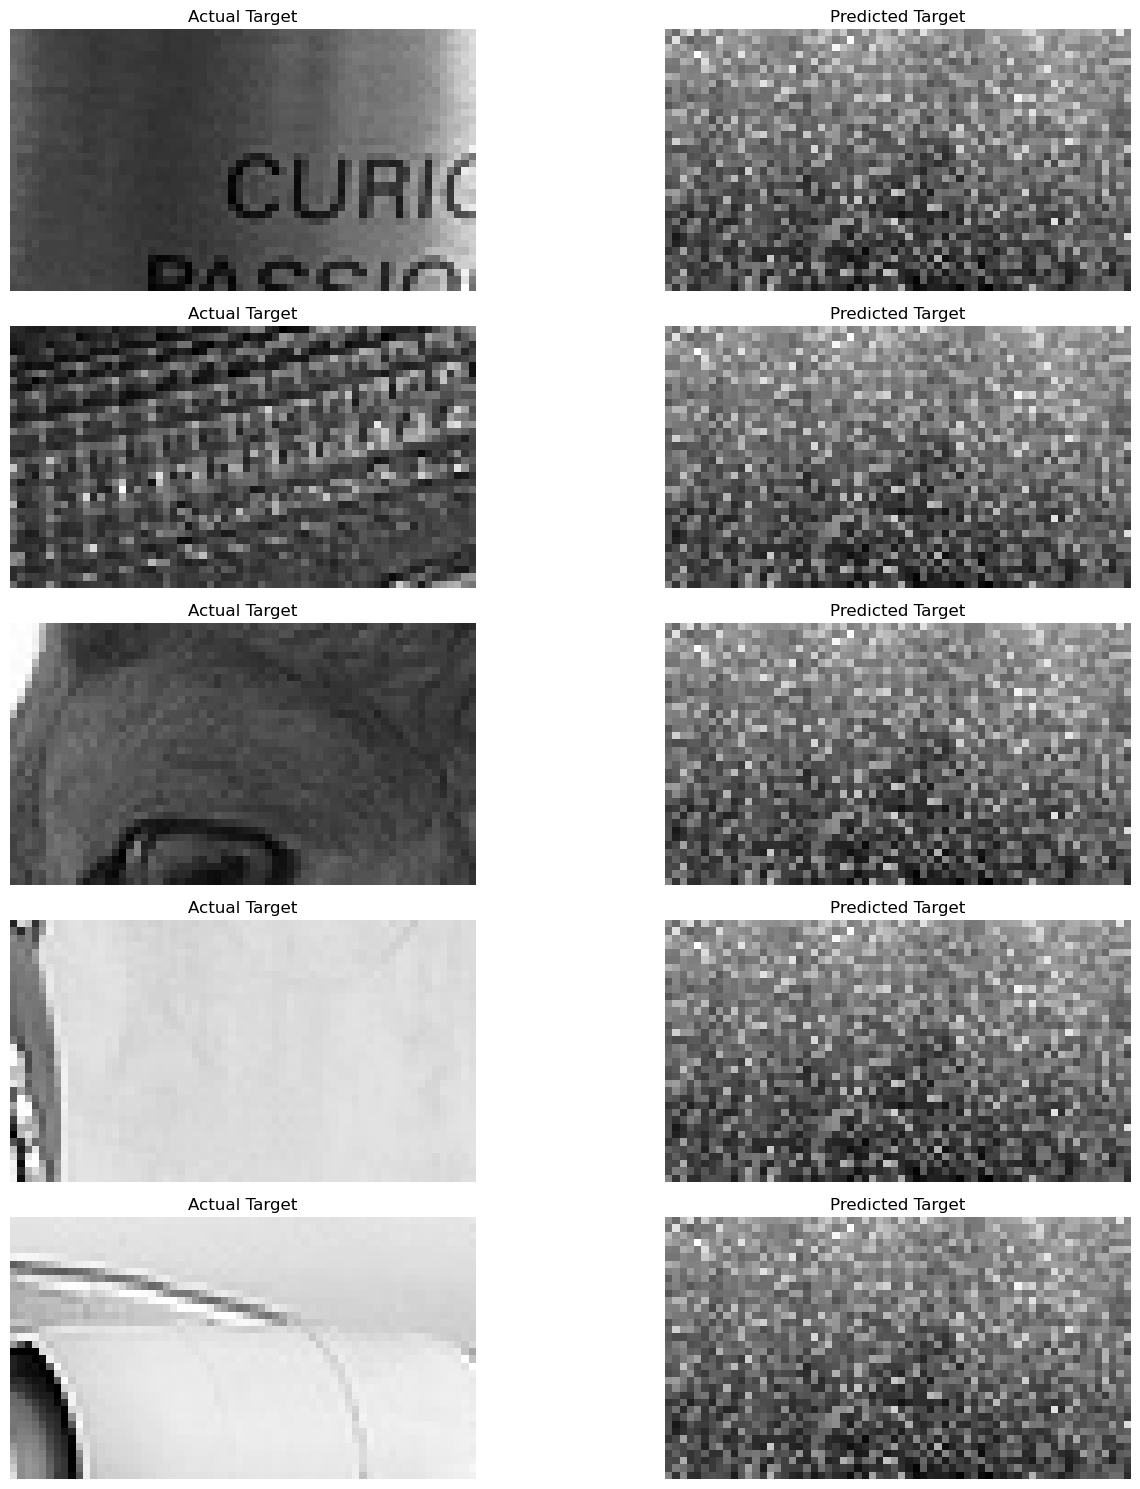

In [5]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, percentage=0.1):
    model.eval()
    test_loss = 0.0
    criterion = nn.MSELoss()
    all_targets = []
    all_predictions = []

    num_batches = int(len(test_loader) * percentage)  # Calculate the number of batches to process
    processed_batches = 0

    with torch.no_grad():
        for grayscale_img, features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.view(target.size(0), -1).to(device)

            # Flatten features
            features = features.view(features.size(0), -1)

            # Predict
            predictions = model(features)
            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(
    mlp_model, test_loader, device, percentage=0.1
)
print(f"Test Loss (First 10%): {test_loss_partial:.4f}")

# Plot Examples
def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].reshape(36, 64), cmap='gray')
        plt.title("Actual Target")
        plt.axis('off')

        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].reshape(36, 64), cmap='gray')
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [6]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-0.1244) tensor(-0.0088)
tensor(-2.0337) tensor(2.3987)
